In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.errors import InvalidArgumentError
import tensorflow as tf

# Tensorflow GPU settings
# gpu_options = tf.GPUOptions(allow_growth=True)#per_process_gpu_memory_fraction=0.5)
# sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import shuffle

from scipy import interpolate

from atlasify import atlasify
import pickle

2022-01-29 04:55:56.876478: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-01-29 04:55:57.706205: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-29 04:55:57.707239: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-01-29 04:55:57.713730: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 4000 computeCapability: 7.5
coreClock: 1.545GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 387.49GiB/s
2022-01-29 04:55:57.713754: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-01-29 04:55:57.715094: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-0

In [2]:
sig = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220117_iso_e4m1_VVZ_RD.arrow')
sig['is_signal'] = True
# sig_test = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/SIG_2021_11_16_no_iso_TEST.arrow')
bg_full = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220117_iso_e4m1_FULLBG_RD.arrow')
bg_full['is_signal'] = False
# bg_test = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/FULLBG_2021_11_16_no_iso_TEST.arrow')

In [3]:
bg_ZZ = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220117_iso_e4m1_ZZ_RD.arrow')
bg_Zjets_old = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20211129_iso_e4m1_Zjets_RD.arrow')
bg_Zjets = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220117_iso_e4m1_Zjets_RD.arrow')
bg_Zgamma = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220117_iso_e4m1_Zgamma_RD.arrow')
bg_WZ = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220117_iso_e4m1_WZ_RD.arrow')
bg_tZ = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220117_iso_e4m1_tZ_RD.arrow')
bg_tWZ = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220117_iso_e4m1_tWZ_RD.arrow')
bg_ttZ = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220117_iso_e4m1_ttZ_RD.arrow')
bg_other = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220117_iso_e4m1_others_RD.arrow')

bg_sources = [bg_ZZ, bg_Zjets, bg_Zgamma, bg_WZ, bg_tZ, bg_tWZ, bg_ttZ, bg_other]

In [4]:
for df in bg_sources:
    print(sum(df.wgt) / sum(bg_full.wgt))

0.9717740665613699
0.008909331116206785
0.0010556883632736617
0.004347097929154949
0.00016711686720929022
0.0025379501654372405
0.005859107932870372
0.006691005792313908


In [5]:
len(bg_Zjets_old)

130

In [6]:
len(bg_Zjets)

132

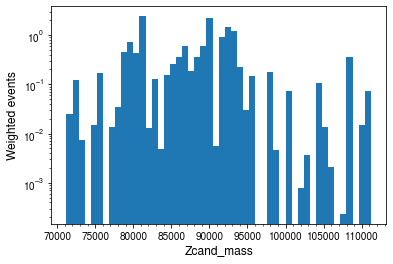

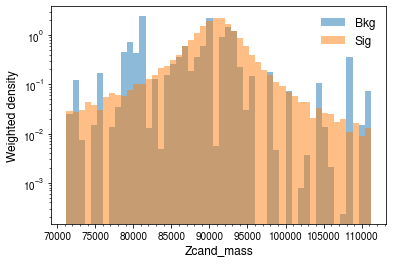

In [7]:
feat = 'Zcand_mass'


bg_source = bg_Zjets

plt.hist(bg_source[feat], weights=bg_source.wgt, bins=50)
plt.yscale('log')

plt.xlabel(feat, fontsize=12)
plt.ylabel('Weighted events', fontsize=12)
plt.minorticks_on()

plt.show()

_, b, _ = plt.hist(bg_source[feat], weights=bg_source.wgt, density=False, bins=50, alpha=0.5, label='Bkg')
plt.hist(sig[feat], weights=sig.wgt, density=False, bins=b, alpha=0.5, label='Sig')

plt.legend(frameon=False, fontsize=12)

plt.xlabel(feat, fontsize=12)
plt.ylabel('Weighted density', fontsize=12)
plt.minorticks_on()

plt.yscale('log')

In [8]:
# train_feats = ['Zlep1_dphi', 'Zlep2_dphi', 'Wlep1_dphi', 'Wlep2_dphi', 'pt_1', 'pt_2', 'Wlep2_pt_sqrt']
# train_feats = ['pt_1', 'pt_2', 'pt_3', 'pt_4', 'pt_4l',
#                'Zlep1_dphi', 'Zlep2_dphi', 'Wlep1_dphi', 'Wlep2_dphi', 
#                'Zlep1_phi', 'Zlep2_phi', 'Wlep1_phi', 'Wlep2_phi', 
#                'Zlep1_eta', 'Zlep2_eta', 'Wlep1_eta', 'Wlep2_eta',
#                'Zlep1_pid', 'Zlep2_pid', 'Wlep1_pid', 'Wlep2_pid',
#                'Zlep1_pt', 'Zlep2_pt', 'Wlep1_pt', 'Wlep2_pt',
#                'METSig', 'MET', 'Nlep', 'Njet',
#                'other_mass', 'leptonic_HT', 'total_HT', 'HT', 
#                'SR']

train_feats_raw = sorted([f for f in sig.columns if f not in ['index', 'wgt', 'is_signal', 'Zcand_mass', 'chisq']])

X = pd.concat([sig[train_feats_raw], bg_full[train_feats_raw]], ignore_index=True)

In [9]:
# Normalize inputs for NN training
min_max_scaler = preprocessing.MinMaxScaler()

min_max_scaler.fit(X)

for df in [sig, bg_full] + bg_sources:
    df[train_feats_raw] = min_max_scaler.transform(df[train_feats_raw])

# Signal vs ttZ

ttZ events account for

In [10]:
current_bg = bg_ttZ
sum(current_bg.wgt) / sum(bg_full.wgt) * 100

0.5859107932870372

percent of the total background. The amount relative to signal is

In [11]:
print('Number:', len(current_bg)/len(sig) * 100, '%')
print('Weight:', sum(current_bg.wgt)/sum(sig.wgt) * 100, '%')

Number: 12.496242409667529 %
Weight: 49.22307684503504 %


Now we can scan over different training setups.

In [12]:
np.asarray(train_feats_raw)

array(['HT', 'MET', 'METSig', 'Njet', 'Nlep', 'SR', 'Wlep1_dphi',
       'Wlep1_eta', 'Wlep1_phi', 'Wlep1_pid', 'Wlep1_pt', 'Wlep2_dphi',
       'Wlep2_eta', 'Wlep2_phi', 'Wlep2_pid', 'Wlep2_pt', 'Zlep1_dphi',
       'Zlep1_eta', 'Zlep1_phi', 'Zlep1_pid', 'Zlep1_pt', 'Zlep2_dphi',
       'Zlep2_eta', 'Zlep2_phi', 'Zlep2_pid', 'Zlep2_pt', 'leptonic_HT',
       'mass_4l', 'other_mass', 'pt_1', 'pt_2', 'pt_3', 'pt_4', 'pt_4l',
       'total_HT'], dtype='<U11')

In [13]:
train_feat_sets = [train_feats_raw, 
                   [f for f in train_feats_raw if f not in ['Wlep1_phi', 'Wlep2_phi', 'Zlep1_phi', 'Zlep2_phi']],
                   [f for f in train_feats_raw if f not in ['MET', 'METSig']],
                   [f for f in train_feats_raw if f not in ['pt_1', 'pt_2', 'pt_3', 'pt_4']],
                   [f for f in train_feats_raw if f not in ['Njet', 'Nlep']]
                  ]

In [ ]:
EPOCHS = 5000
patience = 500
batch_size = 512
num_nodes = 32
dropout = 0.1
learn_rate = 1e-5

for i, train_feats in enumerate(train_feat_sets):
    print('Running with training features:', train_feats)
    # Save training setup
    with open('models/background_id_models/classifier_ttZ_train_feat_test_' + str(i) + '_setup.txt', 
              'w') as file:
        file.write('Epochs: ' + str(EPOCHS) + '\n')
        file.write('Patience: ' + str(patience) + '\n')
        file.write('Learning rate: ' + str(learn_rate) + '\n')
        file.write('Batch size: ' + str(batch_size) + '\n\n')
        file.write('Training features:\n' + '\n'.join(train_feats))
    
    # Generate train and test samples
    sig_train, sig_test = train_test_split(sig[train_feats + ['wgt']], train_size=0.5, random_state=314)
    bg_train, bg_test = train_test_split(current_bg[train_feats + ['wgt']], train_size=0.5, random_state=314)

    n_sig = sum(sig_train.wgt)
    n_bg = sum(bg_train.wgt)

    x_train_sig = sig_train[train_feats]
    x_train_bg = bg_train[train_feats]

    x_train = pd.concat([x_train_sig, x_train_bg])
    y_train = np.concatenate([np.ones(len(sig_train)), np.zeros(len(bg_train))])
    w_train = pd.Series(np.concatenate([(n_sig + n_bg) / n_sig * sig_train['wgt'], 
                                        (n_sig + n_bg) / n_bg * bg_train['wgt']]))

    n_sig_test = sum(sig_test.wgt)
    n_bg_test = sum(bg_test.wgt)

    x_test = pd.concat([sig_test[train_feats], bg_test[train_feats]])
    y_test = np.concatenate([np.ones(len(sig_test)), np.zeros(len(bg_test))])
    w_test = pd.Series(np.concatenate([(n_sig_test + n_bg_test) / n_sig_test * sig_test['wgt'], 
                                       (n_sig_test + n_bg_test) / n_bg_test * bg_test['wgt']]))
    
    # Generate and fit model
    K.clear_session()
    classifier_ttZ = Sequential()
    classifier_ttZ.add(Dense(num_nodes, input_dim=x_train.shape[1], activation='relu')) 
    classifier_ttZ.add(Dropout(dropout))
    classifier_ttZ.add(Dense(num_nodes, activation='relu'))
    classifier_ttZ.add(Dropout(dropout))
    classifier_ttZ.add(Dense(num_nodes, activation='relu'))
    classifier_ttZ.add(Dropout(dropout))
    classifier_ttZ.add(Dense(1, activation='sigmoid'))

    opt = keras.optimizers.Adam(learning_rate=learn_rate)
    classifier_ttZ.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    # Early stopping
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    history = classifier_ttZ.fit(x_train, y_train, epochs=EPOCHS, batch_size=batch_size,
                                 validation_data=(x_test, y_test, w_test), sample_weight=w_train, 
                                 verbose=1, callbacks=[callback], shuffle=True)
    
    # Save model and history
    classifier_ttZ.save('models/background_id_models/classifier_ttZ_train_feat_test_' + str(i))
    with open('models/background_id_models/classifier_ttZ_train_feat_test_' + str(i) + '_history.pkl', 
              'wb') as file_pi:
        pickle.dump(history.history, file_pi)

Running with training features: ['HT', 'MET', 'METSig', 'Njet', 'Nlep', 'SR', 'Wlep1_dphi', 'Wlep1_eta', 'Wlep1_phi', 'Wlep1_pid', 'Wlep1_pt', 'Wlep2_dphi', 'Wlep2_eta', 'Wlep2_phi', 'Wlep2_pid', 'Wlep2_pt', 'Zlep1_dphi', 'Zlep1_eta', 'Zlep1_phi', 'Zlep1_pid', 'Zlep1_pt', 'Zlep2_dphi', 'Zlep2_eta', 'Zlep2_phi', 'Zlep2_pid', 'Zlep2_pt', 'leptonic_HT', 'mass_4l', 'other_mass', 'pt_1', 'pt_2', 'pt_3', 'pt_4', 'pt_4l', 'total_HT']


2022-01-29 04:56:58.848568: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-29 04:56:58.850934: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 4000 computeCapability: 7.5
coreClock: 1.545GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 387.49GiB/s
2022-01-29 04:56:58.851017: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-01-29 04:56:58.851059: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-01-29 04:56:58.851089: I tensorflow/stream_executor/plat

Epoch 1/5000


2022-01-29 04:56:59.730843: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


74/74 [==============================] - 1s 11ms/step - loss: 5.2360e-04 - accuracy: 0.7138 - val_loss: 5.1032e-04 - val_accuracy: 0.7817
Epoch 2/5000
74/74 [==============================] - 1s 7ms/step - loss: 5.1135e-04 - accuracy: 0.7076 - val_loss: 5.1016e-04 - val_accuracy: 0.7717
Epoch 3/5000
74/74 [==============================] - 1s 7ms/step - loss: 5.2211e-04 - accuracy: 0.6983 - val_loss: 5.0998e-04 - val_accuracy: 0.7593
Epoch 4/5000
74/74 [==============================] - 1s 7ms/step - loss: 5.1734e-04 - accuracy: 0.6881 - val_loss: 5.0988e-04 - val_accuracy: 0.7535
Epoch 5/5000
74/74 [==============================] - 1s 7ms/step - loss: 5.3131e-04 - accuracy: 0.6821 - val_loss: 5.0977e-04 - val_accuracy: 0.7456
Epoch 6/5000
74/74 [==============================] - 1s 7ms/step - loss: 5.1384e-04 - accuracy: 0.6733 - val_loss: 5.0965e-04 - val_accuracy: 0.7374
Epoch 7/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.9695e-04 - accuracy: 0.6719 - val_lo

74/74 [==============================] - 1s 7ms/step - loss: 5.1724e-04 - accuracy: 0.5601 - val_loss: 5.0641e-04 - val_accuracy: 0.5835
Epoch 56/5000
74/74 [==============================] - 1s 7ms/step - loss: 5.1094e-04 - accuracy: 0.5633 - val_loss: 5.0637e-04 - val_accuracy: 0.5860
Epoch 57/5000
74/74 [==============================] - 1s 7ms/step - loss: 5.0257e-04 - accuracy: 0.5665 - val_loss: 5.0632e-04 - val_accuracy: 0.5966
Epoch 58/5000
74/74 [==============================] - 1s 7ms/step - loss: 5.0579e-04 - accuracy: 0.5717 - val_loss: 5.0628e-04 - val_accuracy: 0.5955
Epoch 59/5000
74/74 [==============================] - 1s 7ms/step - loss: 5.1164e-04 - accuracy: 0.5742 - val_loss: 5.0623e-04 - val_accuracy: 0.5988
Epoch 60/5000
74/74 [==============================] - 0s 7ms/step - loss: 5.1549e-04 - accuracy: 0.5743 - val_loss: 5.0619e-04 - val_accuracy: 0.6010
Epoch 61/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.9875e-04 - accuracy: 0.5743 - v

74/74 [==============================] - 1s 7ms/step - loss: 5.1302e-04 - accuracy: 0.6355 - val_loss: 5.0370e-04 - val_accuracy: 0.6770
Epoch 110/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.9923e-04 - accuracy: 0.6377 - val_loss: 5.0365e-04 - val_accuracy: 0.6788
Epoch 111/5000
74/74 [==============================] - 1s 7ms/step - loss: 5.0269e-04 - accuracy: 0.6327 - val_loss: 5.0360e-04 - val_accuracy: 0.6783
Epoch 112/5000
74/74 [==============================] - 1s 7ms/step - loss: 5.0663e-04 - accuracy: 0.6309 - val_loss: 5.0355e-04 - val_accuracy: 0.6774
Epoch 113/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.9739e-04 - accuracy: 0.6377 - val_loss: 5.0350e-04 - val_accuracy: 0.6782
Epoch 114/5000
74/74 [==============================] - 1s 7ms/step - loss: 5.1373e-04 - accuracy: 0.6318 - val_loss: 5.0346e-04 - val_accuracy: 0.6793
Epoch 115/5000
74/74 [==============================] - 0s 7ms/step - loss: 5.1574e-04 - accuracy: 0.62

Epoch 163/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.9522e-04 - accuracy: 0.6719 - val_loss: 5.0073e-04 - val_accuracy: 0.7145
Epoch 164/5000
74/74 [==============================] - 1s 7ms/step - loss: 5.0689e-04 - accuracy: 0.6726 - val_loss: 5.0068e-04 - val_accuracy: 0.7143
Epoch 165/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.9333e-04 - accuracy: 0.6746 - val_loss: 5.0062e-04 - val_accuracy: 0.7157
Epoch 166/5000
74/74 [==============================] - 1s 7ms/step - loss: 5.0902e-04 - accuracy: 0.6751 - val_loss: 5.0057e-04 - val_accuracy: 0.7153
Epoch 167/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.8837e-04 - accuracy: 0.6725 - val_loss: 5.0052e-04 - val_accuracy: 0.7164
Epoch 168/5000
74/74 [==============================] - 1s 7ms/step - loss: 5.0492e-04 - accuracy: 0.6726 - val_loss: 5.0046e-04 - val_accuracy: 0.7158
Epoch 169/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.9208e-04 -

Epoch 217/5000
74/74 [==============================] - 0s 7ms/step - loss: 5.0867e-04 - accuracy: 0.6975 - val_loss: 4.9777e-04 - val_accuracy: 0.7312
Epoch 218/5000
74/74 [==============================] - 0s 6ms/step - loss: 4.9423e-04 - accuracy: 0.6992 - val_loss: 4.9771e-04 - val_accuracy: 0.7321
Epoch 219/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.8969e-04 - accuracy: 0.7015 - val_loss: 4.9765e-04 - val_accuracy: 0.7318
Epoch 220/5000
74/74 [==============================] - 0s 6ms/step - loss: 4.9430e-04 - accuracy: 0.7022 - val_loss: 4.9758e-04 - val_accuracy: 0.7309
Epoch 221/5000
74/74 [==============================] - 1s 7ms/step - loss: 5.1782e-04 - accuracy: 0.6970 - val_loss: 4.9753e-04 - val_accuracy: 0.7292
Epoch 222/5000
74/74 [==============================] - 1s 7ms/step - loss: 5.0194e-04 - accuracy: 0.7007 - val_loss: 4.9749e-04 - val_accuracy: 0.7284
Epoch 223/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.9474e-04 -

Epoch 271/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.9921e-04 - accuracy: 0.7135 - val_loss: 4.9443e-04 - val_accuracy: 0.7397
Epoch 272/5000
74/74 [==============================] - 1s 7ms/step - loss: 5.0013e-04 - accuracy: 0.7162 - val_loss: 4.9435e-04 - val_accuracy: 0.7418
Epoch 273/5000
74/74 [==============================] - 0s 7ms/step - loss: 5.0054e-04 - accuracy: 0.7136 - val_loss: 4.9429e-04 - val_accuracy: 0.7410
Epoch 274/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.9803e-04 - accuracy: 0.7112 - val_loss: 4.9421e-04 - val_accuracy: 0.7421
Epoch 275/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.9681e-04 - accuracy: 0.7183 - val_loss: 4.9416e-04 - val_accuracy: 0.7417
Epoch 276/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.9714e-04 - accuracy: 0.7178 - val_loss: 4.9408e-04 - val_accuracy: 0.7419
Epoch 277/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.9031e-04 -

Epoch 325/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.9688e-04 - accuracy: 0.7206 - val_loss: 4.9086e-04 - val_accuracy: 0.7448
Epoch 326/5000
74/74 [==============================] - 1s 7ms/step - loss: 5.0931e-04 - accuracy: 0.7276 - val_loss: 4.9083e-04 - val_accuracy: 0.7443
Epoch 327/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.9312e-04 - accuracy: 0.7286 - val_loss: 4.9076e-04 - val_accuracy: 0.7450
Epoch 328/5000
74/74 [==============================] - 1s 7ms/step - loss: 5.1097e-04 - accuracy: 0.7258 - val_loss: 4.9070e-04 - val_accuracy: 0.7449
Epoch 329/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.9717e-04 - accuracy: 0.7271 - val_loss: 4.9065e-04 - val_accuracy: 0.7460
Epoch 330/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.9897e-04 - accuracy: 0.7249 - val_loss: 4.9060e-04 - val_accuracy: 0.7456
Epoch 331/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.9103e-04 -

Epoch 379/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.8692e-04 - accuracy: 0.7269 - val_loss: 4.8753e-04 - val_accuracy: 0.7440
Epoch 380/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.9910e-04 - accuracy: 0.7244 - val_loss: 4.8744e-04 - val_accuracy: 0.7452
Epoch 381/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.9347e-04 - accuracy: 0.7319 - val_loss: 4.8736e-04 - val_accuracy: 0.7459
Epoch 382/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.7652e-04 - accuracy: 0.7309 - val_loss: 4.8726e-04 - val_accuracy: 0.7467
Epoch 383/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.9306e-04 - accuracy: 0.7294 - val_loss: 4.8720e-04 - val_accuracy: 0.7464
Epoch 384/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.7939e-04 - accuracy: 0.7346 - val_loss: 4.8713e-04 - val_accuracy: 0.7468
Epoch 385/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.7973e-04 -

Epoch 433/5000
74/74 [==============================] - 1s 7ms/step - loss: 5.0193e-04 - accuracy: 0.7314 - val_loss: 4.8456e-04 - val_accuracy: 0.7440
Epoch 434/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.8077e-04 - accuracy: 0.7308 - val_loss: 4.8452e-04 - val_accuracy: 0.7443
Epoch 435/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.9284e-04 - accuracy: 0.7361 - val_loss: 4.8443e-04 - val_accuracy: 0.7454
Epoch 436/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.8450e-04 - accuracy: 0.7346 - val_loss: 4.8435e-04 - val_accuracy: 0.7465
Epoch 437/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.8196e-04 - accuracy: 0.7320 - val_loss: 4.8432e-04 - val_accuracy: 0.7454
Epoch 438/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.8376e-04 - accuracy: 0.7333 - val_loss: 4.8426e-04 - val_accuracy: 0.7464
Epoch 439/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.8224e-04 -

Epoch 487/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.7483e-04 - accuracy: 0.7361 - val_loss: 4.8188e-04 - val_accuracy: 0.7481
Epoch 488/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.8625e-04 - accuracy: 0.7370 - val_loss: 4.8186e-04 - val_accuracy: 0.7469
Epoch 489/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.8853e-04 - accuracy: 0.7399 - val_loss: 4.8185e-04 - val_accuracy: 0.7455
Epoch 490/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.7834e-04 - accuracy: 0.7382 - val_loss: 4.8177e-04 - val_accuracy: 0.7460
Epoch 491/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.7733e-04 - accuracy: 0.7378 - val_loss: 4.8173e-04 - val_accuracy: 0.7460
Epoch 492/5000
74/74 [==============================] - 1s 7ms/step - loss: 5.0397e-04 - accuracy: 0.7394 - val_loss: 4.8168e-04 - val_accuracy: 0.7460
Epoch 493/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.8994e-04 -

Epoch 541/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.7064e-04 - accuracy: 0.7381 - val_loss: 4.7961e-04 - val_accuracy: 0.7438
Epoch 542/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.8902e-04 - accuracy: 0.7353 - val_loss: 4.7956e-04 - val_accuracy: 0.7438
Epoch 543/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.8114e-04 - accuracy: 0.7354 - val_loss: 4.7951e-04 - val_accuracy: 0.7439
Epoch 544/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.8169e-04 - accuracy: 0.7367 - val_loss: 4.7949e-04 - val_accuracy: 0.7435
Epoch 545/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.8735e-04 - accuracy: 0.7352 - val_loss: 4.7944e-04 - val_accuracy: 0.7437
Epoch 546/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.8706e-04 - accuracy: 0.7380 - val_loss: 4.7942e-04 - val_accuracy: 0.7434
Epoch 547/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.8577e-04 -

Epoch 595/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.9014e-04 - accuracy: 0.7354 - val_loss: 4.7742e-04 - val_accuracy: 0.7430
Epoch 596/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.8989e-04 - accuracy: 0.7381 - val_loss: 4.7742e-04 - val_accuracy: 0.7419
Epoch 597/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.9398e-04 - accuracy: 0.7374 - val_loss: 4.7737e-04 - val_accuracy: 0.7421
Epoch 598/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.9443e-04 - accuracy: 0.7331 - val_loss: 4.7731e-04 - val_accuracy: 0.7426
Epoch 599/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.7627e-04 - accuracy: 0.7344 - val_loss: 4.7731e-04 - val_accuracy: 0.7412
Epoch 600/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.6531e-04 - accuracy: 0.7352 - val_loss: 4.7724e-04 - val_accuracy: 0.7422
Epoch 601/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.7905e-04 -

Epoch 649/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.8158e-04 - accuracy: 0.7334 - val_loss: 4.7542e-04 - val_accuracy: 0.7406
Epoch 650/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.7894e-04 - accuracy: 0.7381 - val_loss: 4.7540e-04 - val_accuracy: 0.7399
Epoch 651/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.6106e-04 - accuracy: 0.7312 - val_loss: 4.7534e-04 - val_accuracy: 0.7406
Epoch 652/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.8835e-04 - accuracy: 0.7329 - val_loss: 4.7535e-04 - val_accuracy: 0.7396
Epoch 653/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.7630e-04 - accuracy: 0.7379 - val_loss: 4.7526e-04 - val_accuracy: 0.7408
Epoch 654/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.7024e-04 - accuracy: 0.7353 - val_loss: 4.7523e-04 - val_accuracy: 0.7406
Epoch 655/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.7800e-04 -

Epoch 703/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.8311e-04 - accuracy: 0.7363 - val_loss: 4.7349e-04 - val_accuracy: 0.7412
Epoch 704/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.8266e-04 - accuracy: 0.7385 - val_loss: 4.7342e-04 - val_accuracy: 0.7422
Epoch 705/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.7565e-04 - accuracy: 0.7355 - val_loss: 4.7337e-04 - val_accuracy: 0.7421
Epoch 706/5000
74/74 [==============================] - 0s 6ms/step - loss: 4.8177e-04 - accuracy: 0.7401 - val_loss: 4.7336e-04 - val_accuracy: 0.7414
Epoch 707/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.7367e-04 - accuracy: 0.7384 - val_loss: 4.7333e-04 - val_accuracy: 0.7414
Epoch 708/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.6820e-04 - accuracy: 0.7378 - val_loss: 4.7329e-04 - val_accuracy: 0.7418
Epoch 709/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.7684e-04 -

Epoch 757/5000
74/74 [==============================] - 1s 7ms/step - loss: 5.0126e-04 - accuracy: 0.7319 - val_loss: 4.7166e-04 - val_accuracy: 0.7394
Epoch 758/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.7704e-04 - accuracy: 0.7364 - val_loss: 4.7159e-04 - val_accuracy: 0.7404
Epoch 759/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.7736e-04 - accuracy: 0.7373 - val_loss: 4.7156e-04 - val_accuracy: 0.7405
Epoch 760/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.7574e-04 - accuracy: 0.7383 - val_loss: 4.7152e-04 - val_accuracy: 0.7405
Epoch 761/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.7462e-04 - accuracy: 0.7343 - val_loss: 4.7148e-04 - val_accuracy: 0.7409
Epoch 762/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.6911e-04 - accuracy: 0.7391 - val_loss: 4.7146e-04 - val_accuracy: 0.7404
Epoch 763/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.7964e-04 -

Epoch 811/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.7889e-04 - accuracy: 0.7383 - val_loss: 4.6975e-04 - val_accuracy: 0.7415
Epoch 812/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.7420e-04 - accuracy: 0.7363 - val_loss: 4.6971e-04 - val_accuracy: 0.7416
Epoch 813/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.8890e-04 - accuracy: 0.7358 - val_loss: 4.6967e-04 - val_accuracy: 0.7417
Epoch 814/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.7333e-04 - accuracy: 0.7389 - val_loss: 4.6960e-04 - val_accuracy: 0.7429
Epoch 815/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.7820e-04 - accuracy: 0.7320 - val_loss: 4.6959e-04 - val_accuracy: 0.7414
Epoch 816/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.6917e-04 - accuracy: 0.7391 - val_loss: 4.6955e-04 - val_accuracy: 0.7424
Epoch 817/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.6538e-04 -

Epoch 865/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.7819e-04 - accuracy: 0.7412 - val_loss: 4.6786e-04 - val_accuracy: 0.7415
Epoch 866/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5597e-04 - accuracy: 0.7391 - val_loss: 4.6782e-04 - val_accuracy: 0.7417
Epoch 867/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.8060e-04 - accuracy: 0.7394 - val_loss: 4.6778e-04 - val_accuracy: 0.7416
Epoch 868/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.6424e-04 - accuracy: 0.7388 - val_loss: 4.6777e-04 - val_accuracy: 0.7414
Epoch 869/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.8015e-04 - accuracy: 0.7307 - val_loss: 4.6773e-04 - val_accuracy: 0.7415
Epoch 870/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.8099e-04 - accuracy: 0.7376 - val_loss: 4.6773e-04 - val_accuracy: 0.7406
Epoch 871/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5403e-04 -

Epoch 919/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5959e-04 - accuracy: 0.7351 - val_loss: 4.6597e-04 - val_accuracy: 0.7417
Epoch 920/5000
74/74 [==============================] - 0s 6ms/step - loss: 4.6052e-04 - accuracy: 0.7361 - val_loss: 4.6596e-04 - val_accuracy: 0.7408
Epoch 921/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.6786e-04 - accuracy: 0.7354 - val_loss: 4.6589e-04 - val_accuracy: 0.7419
Epoch 922/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.7155e-04 - accuracy: 0.7346 - val_loss: 4.6585e-04 - val_accuracy: 0.7422
Epoch 923/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5627e-04 - accuracy: 0.7382 - val_loss: 4.6582e-04 - val_accuracy: 0.7420
Epoch 924/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.6745e-04 - accuracy: 0.7331 - val_loss: 4.6578e-04 - val_accuracy: 0.7418
Epoch 925/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.6702e-04 -

Epoch 973/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.7174e-04 - accuracy: 0.7354 - val_loss: 4.6437e-04 - val_accuracy: 0.7393
Epoch 974/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.7943e-04 - accuracy: 0.7300 - val_loss: 4.6435e-04 - val_accuracy: 0.7391
Epoch 975/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.7335e-04 - accuracy: 0.7322 - val_loss: 4.6431e-04 - val_accuracy: 0.7394
Epoch 976/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.7221e-04 - accuracy: 0.7370 - val_loss: 4.6422e-04 - val_accuracy: 0.7412
Epoch 977/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.6071e-04 - accuracy: 0.7377 - val_loss: 4.6416e-04 - val_accuracy: 0.7418
Epoch 978/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.6736e-04 - accuracy: 0.7352 - val_loss: 4.6415e-04 - val_accuracy: 0.7415
Epoch 979/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.6604e-04 -

Epoch 1027/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.8502e-04 - accuracy: 0.7287 - val_loss: 4.6258e-04 - val_accuracy: 0.7384
Epoch 1028/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.7022e-04 - accuracy: 0.7321 - val_loss: 4.6251e-04 - val_accuracy: 0.7388
Epoch 1029/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.7369e-04 - accuracy: 0.7282 - val_loss: 4.6245e-04 - val_accuracy: 0.7391
Epoch 1030/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.6376e-04 - accuracy: 0.7338 - val_loss: 4.6238e-04 - val_accuracy: 0.7403
Epoch 1031/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.6815e-04 - accuracy: 0.7325 - val_loss: 4.6236e-04 - val_accuracy: 0.7391
Epoch 1032/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.6276e-04 - accuracy: 0.7356 - val_loss: 4.6234e-04 - val_accuracy: 0.7387
Epoch 1033/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.583

74/74 [==============================] - 1s 7ms/step - loss: 4.6483e-04 - accuracy: 0.7369 - val_loss: 4.6061e-04 - val_accuracy: 0.7417
Epoch 1081/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.6896e-04 - accuracy: 0.7330 - val_loss: 4.6056e-04 - val_accuracy: 0.7424
Epoch 1082/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.5880e-04 - accuracy: 0.7389 - val_loss: 4.6051e-04 - val_accuracy: 0.7427
Epoch 1083/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.6789e-04 - accuracy: 0.7345 - val_loss: 4.6052e-04 - val_accuracy: 0.7411
Epoch 1084/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4854e-04 - accuracy: 0.7348 - val_loss: 4.6050e-04 - val_accuracy: 0.7405
Epoch 1085/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.7561e-04 - accuracy: 0.7334 - val_loss: 4.6048e-04 - val_accuracy: 0.7396
Epoch 1086/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.6810e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.7146e-04 - accuracy: 0.7307 - val_loss: 4.5875e-04 - val_accuracy: 0.7394
Epoch 1134/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.8530e-04 - accuracy: 0.7338 - val_loss: 4.5875e-04 - val_accuracy: 0.7385
Epoch 1135/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5620e-04 - accuracy: 0.7319 - val_loss: 4.5871e-04 - val_accuracy: 0.7386
Epoch 1136/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5956e-04 - accuracy: 0.7323 - val_loss: 4.5863e-04 - val_accuracy: 0.7404
Epoch 1137/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.7387e-04 - accuracy: 0.7301 - val_loss: 4.5863e-04 - val_accuracy: 0.7388
Epoch 1138/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5604e-04 - accuracy: 0.7317 - val_loss: 4.5860e-04 - val_accuracy: 0.7389
Epoch 1139/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.6101e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.7436e-04 - accuracy: 0.7333 - val_loss: 4.5695e-04 - val_accuracy: 0.7410
Epoch 1187/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.5199e-04 - accuracy: 0.7325 - val_loss: 4.5690e-04 - val_accuracy: 0.7421
Epoch 1188/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.7490e-04 - accuracy: 0.7322 - val_loss: 4.5691e-04 - val_accuracy: 0.7405
Epoch 1189/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.6027e-04 - accuracy: 0.7328 - val_loss: 4.5686e-04 - val_accuracy: 0.7410
Epoch 1190/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4835e-04 - accuracy: 0.7303 - val_loss: 4.5686e-04 - val_accuracy: 0.7390
Epoch 1191/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.5529e-04 - accuracy: 0.7385 - val_loss: 4.5683e-04 - val_accuracy: 0.7387
Epoch 1192/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.7609e-04 - accuracy

74/74 [==============================] - 0s 7ms/step - loss: 4.4858e-04 - accuracy: 0.7327 - val_loss: 4.5502e-04 - val_accuracy: 0.7424
Epoch 1240/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.6748e-04 - accuracy: 0.7340 - val_loss: 4.5500e-04 - val_accuracy: 0.7417
Epoch 1241/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5311e-04 - accuracy: 0.7337 - val_loss: 4.5496e-04 - val_accuracy: 0.7417
Epoch 1242/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.7316e-04 - accuracy: 0.7365 - val_loss: 4.5494e-04 - val_accuracy: 0.7420
Epoch 1243/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.6999e-04 - accuracy: 0.7283 - val_loss: 4.5487e-04 - val_accuracy: 0.7433
Epoch 1244/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.6237e-04 - accuracy: 0.7310 - val_loss: 4.5485e-04 - val_accuracy: 0.7428
Epoch 1245/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.8232e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.7417e-04 - accuracy: 0.7289 - val_loss: 4.5333e-04 - val_accuracy: 0.7410
Epoch 1293/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5196e-04 - accuracy: 0.7352 - val_loss: 4.5330e-04 - val_accuracy: 0.7414
Epoch 1294/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.6468e-04 - accuracy: 0.7305 - val_loss: 4.5327e-04 - val_accuracy: 0.7418
Epoch 1295/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.7573e-04 - accuracy: 0.7339 - val_loss: 4.5321e-04 - val_accuracy: 0.7424
Epoch 1296/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4009e-04 - accuracy: 0.7349 - val_loss: 4.5317e-04 - val_accuracy: 0.7430
Epoch 1297/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.6410e-04 - accuracy: 0.7362 - val_loss: 4.5314e-04 - val_accuracy: 0.7420
Epoch 1298/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4937e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.5543e-04 - accuracy: 0.7285 - val_loss: 4.5147e-04 - val_accuracy: 0.7417
Epoch 1346/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.5331e-04 - accuracy: 0.7292 - val_loss: 4.5152e-04 - val_accuracy: 0.7390
Epoch 1347/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.6070e-04 - accuracy: 0.7274 - val_loss: 4.5147e-04 - val_accuracy: 0.7397
Epoch 1348/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.7029e-04 - accuracy: 0.7279 - val_loss: 4.5148e-04 - val_accuracy: 0.7383
Epoch 1349/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.6182e-04 - accuracy: 0.7283 - val_loss: 4.5139e-04 - val_accuracy: 0.7405
Epoch 1350/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5801e-04 - accuracy: 0.7300 - val_loss: 4.5132e-04 - val_accuracy: 0.7408
Epoch 1351/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.5727e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.5198e-04 - accuracy: 0.7290 - val_loss: 4.4986e-04 - val_accuracy: 0.7413
Epoch 1399/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5393e-04 - accuracy: 0.7307 - val_loss: 4.4978e-04 - val_accuracy: 0.7427
Epoch 1400/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5890e-04 - accuracy: 0.7302 - val_loss: 4.4972e-04 - val_accuracy: 0.7436
Epoch 1401/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.5320e-04 - accuracy: 0.7324 - val_loss: 4.4972e-04 - val_accuracy: 0.7423
Epoch 1402/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5838e-04 - accuracy: 0.7274 - val_loss: 4.4967e-04 - val_accuracy: 0.7423
Epoch 1403/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5786e-04 - accuracy: 0.7318 - val_loss: 4.4962e-04 - val_accuracy: 0.7426
Epoch 1404/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.5613e-04 - accuracy

74/74 [==============================] - 0s 7ms/step - loss: 4.5203e-04 - accuracy: 0.7247 - val_loss: 4.4828e-04 - val_accuracy: 0.7411
Epoch 1452/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.3744e-04 - accuracy: 0.7325 - val_loss: 4.4825e-04 - val_accuracy: 0.7410
Epoch 1453/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5358e-04 - accuracy: 0.7261 - val_loss: 4.4828e-04 - val_accuracy: 0.7385
Epoch 1454/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5567e-04 - accuracy: 0.7285 - val_loss: 4.4824e-04 - val_accuracy: 0.7393
Epoch 1455/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4872e-04 - accuracy: 0.7273 - val_loss: 4.4821e-04 - val_accuracy: 0.7395
Epoch 1456/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.7508e-04 - accuracy: 0.7283 - val_loss: 4.4818e-04 - val_accuracy: 0.7406
Epoch 1457/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5542e-04 - accuracy

74/74 [==============================] - 0s 7ms/step - loss: 4.5817e-04 - accuracy: 0.7301 - val_loss: 4.4678e-04 - val_accuracy: 0.7433
Epoch 1505/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4632e-04 - accuracy: 0.7369 - val_loss: 4.4677e-04 - val_accuracy: 0.7426
Epoch 1506/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5286e-04 - accuracy: 0.7281 - val_loss: 4.4675e-04 - val_accuracy: 0.7423
Epoch 1507/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.3256e-04 - accuracy: 0.7346 - val_loss: 4.4670e-04 - val_accuracy: 0.7430
Epoch 1508/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4384e-04 - accuracy: 0.7317 - val_loss: 4.4667e-04 - val_accuracy: 0.7430
Epoch 1509/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.6680e-04 - accuracy: 0.7311 - val_loss: 4.4669e-04 - val_accuracy: 0.7413
Epoch 1510/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4129e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.5014e-04 - accuracy: 0.7301 - val_loss: 4.4537e-04 - val_accuracy: 0.7416
Epoch 1558/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4327e-04 - accuracy: 0.7324 - val_loss: 4.4530e-04 - val_accuracy: 0.7426
Epoch 1559/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.6621e-04 - accuracy: 0.7304 - val_loss: 4.4529e-04 - val_accuracy: 0.7419
Epoch 1560/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4387e-04 - accuracy: 0.7289 - val_loss: 4.4525e-04 - val_accuracy: 0.7426
Epoch 1561/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.6704e-04 - accuracy: 0.7322 - val_loss: 4.4525e-04 - val_accuracy: 0.7415
Epoch 1562/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.5638e-04 - accuracy: 0.7350 - val_loss: 4.4514e-04 - val_accuracy: 0.7446
Epoch 1563/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4993e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.6071e-04 - accuracy: 0.7358 - val_loss: 4.4384e-04 - val_accuracy: 0.7424
Epoch 1611/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4843e-04 - accuracy: 0.7280 - val_loss: 4.4380e-04 - val_accuracy: 0.7435
Epoch 1612/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.6860e-04 - accuracy: 0.7322 - val_loss: 4.4381e-04 - val_accuracy: 0.7410
Epoch 1613/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4521e-04 - accuracy: 0.7323 - val_loss: 4.4379e-04 - val_accuracy: 0.7423
Epoch 1614/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5967e-04 - accuracy: 0.7269 - val_loss: 4.4377e-04 - val_accuracy: 0.7420
Epoch 1615/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.6119e-04 - accuracy: 0.7330 - val_loss: 4.4374e-04 - val_accuracy: 0.7424
Epoch 1616/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4023e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.3029e-04 - accuracy: 0.7323 - val_loss: 4.4258e-04 - val_accuracy: 0.7419
Epoch 1664/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.5604e-04 - accuracy: 0.7342 - val_loss: 4.4258e-04 - val_accuracy: 0.7411
Epoch 1665/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5508e-04 - accuracy: 0.7303 - val_loss: 4.4254e-04 - val_accuracy: 0.7423
Epoch 1666/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.4471e-04 - accuracy: 0.7318 - val_loss: 4.4250e-04 - val_accuracy: 0.7446
Epoch 1667/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4765e-04 - accuracy: 0.7423 - val_loss: 4.4245e-04 - val_accuracy: 0.7445
Epoch 1668/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5878e-04 - accuracy: 0.7318 - val_loss: 4.4246e-04 - val_accuracy: 0.7433
Epoch 1669/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5271e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.5694e-04 - accuracy: 0.7368 - val_loss: 4.4130e-04 - val_accuracy: 0.7422
Epoch 1717/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.3922e-04 - accuracy: 0.7335 - val_loss: 4.4129e-04 - val_accuracy: 0.7420
Epoch 1718/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4523e-04 - accuracy: 0.7340 - val_loss: 4.4124e-04 - val_accuracy: 0.7432
Epoch 1719/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.3301e-04 - accuracy: 0.7362 - val_loss: 4.4122e-04 - val_accuracy: 0.7434
Epoch 1720/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4483e-04 - accuracy: 0.7287 - val_loss: 4.4124e-04 - val_accuracy: 0.7423
Epoch 1721/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.3989e-04 - accuracy: 0.7350 - val_loss: 4.4122e-04 - val_accuracy: 0.7411
Epoch 1722/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.4341e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.4081e-04 - accuracy: 0.7278 - val_loss: 4.4018e-04 - val_accuracy: 0.7412
Epoch 1770/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.6309e-04 - accuracy: 0.7268 - val_loss: 4.4023e-04 - val_accuracy: 0.7386
Epoch 1771/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4198e-04 - accuracy: 0.7332 - val_loss: 4.4018e-04 - val_accuracy: 0.7397
Epoch 1772/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4577e-04 - accuracy: 0.7309 - val_loss: 4.4013e-04 - val_accuracy: 0.7410
Epoch 1773/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5001e-04 - accuracy: 0.7303 - val_loss: 4.4007e-04 - val_accuracy: 0.7424
Epoch 1774/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5211e-04 - accuracy: 0.7317 - val_loss: 4.4004e-04 - val_accuracy: 0.7438
Epoch 1775/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5721e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.4040e-04 - accuracy: 0.7304 - val_loss: 4.3927e-04 - val_accuracy: 0.7390
Epoch 1823/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4351e-04 - accuracy: 0.7279 - val_loss: 4.3922e-04 - val_accuracy: 0.7394
Epoch 1824/5000
74/74 [==============================] - 0s 6ms/step - loss: 4.3870e-04 - accuracy: 0.7307 - val_loss: 4.3919e-04 - val_accuracy: 0.7395
Epoch 1825/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.3851e-04 - accuracy: 0.7296 - val_loss: 4.3916e-04 - val_accuracy: 0.7397
Epoch 1826/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4401e-04 - accuracy: 0.7265 - val_loss: 4.3909e-04 - val_accuracy: 0.7404
Epoch 1827/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4392e-04 - accuracy: 0.7273 - val_loss: 4.3904e-04 - val_accuracy: 0.7412
Epoch 1828/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4302e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.3027e-04 - accuracy: 0.7395 - val_loss: 4.3795e-04 - val_accuracy: 0.7438
Epoch 1876/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.3048e-04 - accuracy: 0.7364 - val_loss: 4.3791e-04 - val_accuracy: 0.7441
Epoch 1877/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5377e-04 - accuracy: 0.7360 - val_loss: 4.3790e-04 - val_accuracy: 0.7437
Epoch 1878/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1951e-04 - accuracy: 0.7356 - val_loss: 4.3787e-04 - val_accuracy: 0.7436
Epoch 1879/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4156e-04 - accuracy: 0.7353 - val_loss: 4.3785e-04 - val_accuracy: 0.7425
Epoch 1880/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4102e-04 - accuracy: 0.7323 - val_loss: 4.3784e-04 - val_accuracy: 0.7426
Epoch 1881/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4870e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.2851e-04 - accuracy: 0.7371 - val_loss: 4.3687e-04 - val_accuracy: 0.7463
Epoch 1929/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.4057e-04 - accuracy: 0.7369 - val_loss: 4.3689e-04 - val_accuracy: 0.7445
Epoch 1930/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.2800e-04 - accuracy: 0.7298 - val_loss: 4.3693e-04 - val_accuracy: 0.7421
Epoch 1931/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.2815e-04 - accuracy: 0.7349 - val_loss: 4.3691e-04 - val_accuracy: 0.7436
Epoch 1932/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5434e-04 - accuracy: 0.7342 - val_loss: 4.3692e-04 - val_accuracy: 0.7427
Epoch 1933/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4690e-04 - accuracy: 0.7315 - val_loss: 4.3688e-04 - val_accuracy: 0.7433
Epoch 1934/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4861e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.5282e-04 - accuracy: 0.7320 - val_loss: 4.3604e-04 - val_accuracy: 0.7452
Epoch 1982/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.3638e-04 - accuracy: 0.7383 - val_loss: 4.3602e-04 - val_accuracy: 0.7459
Epoch 1983/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5336e-04 - accuracy: 0.7335 - val_loss: 4.3598e-04 - val_accuracy: 0.7459
Epoch 1984/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.4661e-04 - accuracy: 0.7372 - val_loss: 4.3600e-04 - val_accuracy: 0.7449
Epoch 1985/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.3961e-04 - accuracy: 0.7337 - val_loss: 4.3599e-04 - val_accuracy: 0.7435
Epoch 1986/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.3652e-04 - accuracy: 0.7375 - val_loss: 4.3594e-04 - val_accuracy: 0.7445
Epoch 1987/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5042e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.3141e-04 - accuracy: 0.7359 - val_loss: 4.3467e-04 - val_accuracy: 0.7484
Epoch 2035/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.3972e-04 - accuracy: 0.7372 - val_loss: 4.3469e-04 - val_accuracy: 0.7476
Epoch 2036/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4260e-04 - accuracy: 0.7358 - val_loss: 4.3466e-04 - val_accuracy: 0.7482
Epoch 2037/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.4286e-04 - accuracy: 0.7369 - val_loss: 4.3461e-04 - val_accuracy: 0.7502
Epoch 2038/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4692e-04 - accuracy: 0.7365 - val_loss: 4.3460e-04 - val_accuracy: 0.7490
Epoch 2039/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5672e-04 - accuracy: 0.7366 - val_loss: 4.3458e-04 - val_accuracy: 0.7494
Epoch 2040/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.3609e-04 - accuracy

74/74 [==============================] - 0s 7ms/step - loss: 4.2953e-04 - accuracy: 0.7378 - val_loss: 4.3377e-04 - val_accuracy: 0.7463
Epoch 2088/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4657e-04 - accuracy: 0.7356 - val_loss: 4.3375e-04 - val_accuracy: 0.7463
Epoch 2089/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4515e-04 - accuracy: 0.7330 - val_loss: 4.3383e-04 - val_accuracy: 0.7446
Epoch 2090/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.3655e-04 - accuracy: 0.7301 - val_loss: 4.3382e-04 - val_accuracy: 0.7449
Epoch 2091/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.3674e-04 - accuracy: 0.7373 - val_loss: 4.3379e-04 - val_accuracy: 0.7454
Epoch 2092/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5149e-04 - accuracy: 0.7307 - val_loss: 4.3371e-04 - val_accuracy: 0.7471
Epoch 2093/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.3719e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.3462e-04 - accuracy: 0.7352 - val_loss: 4.3290e-04 - val_accuracy: 0.7465
Epoch 2141/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.3181e-04 - accuracy: 0.7375 - val_loss: 4.3289e-04 - val_accuracy: 0.7461
Epoch 2142/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5575e-04 - accuracy: 0.7338 - val_loss: 4.3281e-04 - val_accuracy: 0.7470
Epoch 2143/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.3116e-04 - accuracy: 0.7345 - val_loss: 4.3274e-04 - val_accuracy: 0.7490
Epoch 2144/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.3238e-04 - accuracy: 0.7363 - val_loss: 4.3272e-04 - val_accuracy: 0.7491
Epoch 2145/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4552e-04 - accuracy: 0.7425 - val_loss: 4.3271e-04 - val_accuracy: 0.7492
Epoch 2146/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.3692e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.3898e-04 - accuracy: 0.7296 - val_loss: 4.3191e-04 - val_accuracy: 0.7486
Epoch 2194/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4732e-04 - accuracy: 0.7344 - val_loss: 4.3190e-04 - val_accuracy: 0.7473
Epoch 2195/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4649e-04 - accuracy: 0.7302 - val_loss: 4.3187e-04 - val_accuracy: 0.7471
Epoch 2196/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.3984e-04 - accuracy: 0.7348 - val_loss: 4.3182e-04 - val_accuracy: 0.7485
Epoch 2197/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4725e-04 - accuracy: 0.7370 - val_loss: 4.3183e-04 - val_accuracy: 0.7467
Epoch 2198/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.4578e-04 - accuracy: 0.7332 - val_loss: 4.3183e-04 - val_accuracy: 0.7472
Epoch 2199/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.3203e-04 - accuracy

74/74 [==============================] - 0s 7ms/step - loss: 4.5668e-04 - accuracy: 0.7342 - val_loss: 4.3097e-04 - val_accuracy: 0.7498
Epoch 2247/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.3781e-04 - accuracy: 0.7419 - val_loss: 4.3097e-04 - val_accuracy: 0.7493
Epoch 2248/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.3411e-04 - accuracy: 0.7375 - val_loss: 4.3103e-04 - val_accuracy: 0.7471
Epoch 2249/5000
74/74 [==============================] - 0s 6ms/step - loss: 4.2802e-04 - accuracy: 0.7350 - val_loss: 4.3097e-04 - val_accuracy: 0.7498
Epoch 2250/5000
74/74 [==============================] - 0s 6ms/step - loss: 4.3739e-04 - accuracy: 0.7421 - val_loss: 4.3095e-04 - val_accuracy: 0.7492
Epoch 2251/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.3545e-04 - accuracy: 0.7380 - val_loss: 4.3090e-04 - val_accuracy: 0.7501
Epoch 2252/5000
74/74 [==============================] - 0s 6ms/step - loss: 4.3000e-04 - accuracy

74/74 [==============================] - 0s 6ms/step - loss: 4.3890e-04 - accuracy: 0.7311 - val_loss: 4.3011e-04 - val_accuracy: 0.7485
Epoch 2300/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.2277e-04 - accuracy: 0.7408 - val_loss: 4.3007e-04 - val_accuracy: 0.7496
Epoch 2301/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.3309e-04 - accuracy: 0.7370 - val_loss: 4.3007e-04 - val_accuracy: 0.7496
Epoch 2302/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.4740e-04 - accuracy: 0.7391 - val_loss: 4.3002e-04 - val_accuracy: 0.7507
Epoch 2303/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.3855e-04 - accuracy: 0.7362 - val_loss: 4.3004e-04 - val_accuracy: 0.7489
Epoch 2304/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.2548e-04 - accuracy: 0.7388 - val_loss: 4.3000e-04 - val_accuracy: 0.7494
Epoch 2305/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.3978e-04 - accuracy

74/74 [==============================] - 0s 6ms/step - loss: 4.4003e-04 - accuracy: 0.7370 - val_loss: 4.2906e-04 - val_accuracy: 0.7488
Epoch 2353/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.4118e-04 - accuracy: 0.7376 - val_loss: 4.2915e-04 - val_accuracy: 0.7463
Epoch 2354/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.2527e-04 - accuracy: 0.7356 - val_loss: 4.2908e-04 - val_accuracy: 0.7481
Epoch 2355/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.2120e-04 - accuracy: 0.7402 - val_loss: 4.2904e-04 - val_accuracy: 0.7485
Epoch 2356/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.3523e-04 - accuracy: 0.7339 - val_loss: 4.2901e-04 - val_accuracy: 0.7482
Epoch 2357/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.3235e-04 - accuracy: 0.7392 - val_loss: 4.2900e-04 - val_accuracy: 0.7484
Epoch 2358/5000
74/74 [==============================] - 0s 6ms/step - loss: 4.4790e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.2992e-04 - accuracy: 0.7374 - val_loss: 4.2821e-04 - val_accuracy: 0.7500
Epoch 2406/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.3727e-04 - accuracy: 0.7385 - val_loss: 4.2824e-04 - val_accuracy: 0.7494
Epoch 2407/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1956e-04 - accuracy: 0.7431 - val_loss: 4.2821e-04 - val_accuracy: 0.7493
Epoch 2408/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.3432e-04 - accuracy: 0.7329 - val_loss: 4.2819e-04 - val_accuracy: 0.7496
Epoch 2409/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.3001e-04 - accuracy: 0.7339 - val_loss: 4.2817e-04 - val_accuracy: 0.7502
Epoch 2410/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.2082e-04 - accuracy: 0.7381 - val_loss: 4.2811e-04 - val_accuracy: 0.7510
Epoch 2411/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.2634e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.2937e-04 - accuracy: 0.7419 - val_loss: 4.2749e-04 - val_accuracy: 0.7532
Epoch 2459/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.2285e-04 - accuracy: 0.7423 - val_loss: 4.2748e-04 - val_accuracy: 0.7514
Epoch 2460/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.3207e-04 - accuracy: 0.7395 - val_loss: 4.2745e-04 - val_accuracy: 0.7527
Epoch 2461/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4164e-04 - accuracy: 0.7381 - val_loss: 4.2742e-04 - val_accuracy: 0.7537
Epoch 2462/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.2288e-04 - accuracy: 0.7414 - val_loss: 4.2742e-04 - val_accuracy: 0.7529
Epoch 2463/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5337e-04 - accuracy: 0.7375 - val_loss: 4.2743e-04 - val_accuracy: 0.7534
Epoch 2464/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.3444e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.3775e-04 - accuracy: 0.7398 - val_loss: 4.2672e-04 - val_accuracy: 0.7521
Epoch 2512/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.3190e-04 - accuracy: 0.7401 - val_loss: 4.2671e-04 - val_accuracy: 0.7521
Epoch 2513/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.3240e-04 - accuracy: 0.7414 - val_loss: 4.2664e-04 - val_accuracy: 0.7541
Epoch 2514/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.2119e-04 - accuracy: 0.7416 - val_loss: 4.2668e-04 - val_accuracy: 0.7518
Epoch 2515/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.3554e-04 - accuracy: 0.7377 - val_loss: 4.2668e-04 - val_accuracy: 0.7509
Epoch 2516/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4200e-04 - accuracy: 0.7420 - val_loss: 4.2663e-04 - val_accuracy: 0.7527
Epoch 2517/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4194e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.1980e-04 - accuracy: 0.7361 - val_loss: 4.2606e-04 - val_accuracy: 0.7516
Epoch 2565/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.2692e-04 - accuracy: 0.7384 - val_loss: 4.2597e-04 - val_accuracy: 0.7539
Epoch 2566/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1871e-04 - accuracy: 0.7468 - val_loss: 4.2596e-04 - val_accuracy: 0.7540
Epoch 2567/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.2735e-04 - accuracy: 0.7372 - val_loss: 4.2597e-04 - val_accuracy: 0.7537
Epoch 2568/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.3562e-04 - accuracy: 0.7372 - val_loss: 4.2597e-04 - val_accuracy: 0.7529
Epoch 2569/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.3480e-04 - accuracy: 0.7412 - val_loss: 4.2597e-04 - val_accuracy: 0.7529
Epoch 2570/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.3085e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.2926e-04 - accuracy: 0.7400 - val_loss: 4.2548e-04 - val_accuracy: 0.7531
Epoch 2618/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.3589e-04 - accuracy: 0.7375 - val_loss: 4.2548e-04 - val_accuracy: 0.7529
Epoch 2619/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1487e-04 - accuracy: 0.7400 - val_loss: 4.2544e-04 - val_accuracy: 0.7537
Epoch 2620/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1723e-04 - accuracy: 0.7419 - val_loss: 4.2541e-04 - val_accuracy: 0.7538
Epoch 2621/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.2708e-04 - accuracy: 0.7384 - val_loss: 4.2542e-04 - val_accuracy: 0.7538
Epoch 2622/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1870e-04 - accuracy: 0.7381 - val_loss: 4.2542e-04 - val_accuracy: 0.7533
Epoch 2623/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.2963e-04 - accuracy

74/74 [==============================] - 0s 7ms/step - loss: 4.2505e-04 - accuracy: 0.7375 - val_loss: 4.2479e-04 - val_accuracy: 0.7516
Epoch 2671/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.2223e-04 - accuracy: 0.7420 - val_loss: 4.2472e-04 - val_accuracy: 0.7538
Epoch 2672/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.2824e-04 - accuracy: 0.7444 - val_loss: 4.2468e-04 - val_accuracy: 0.7546
Epoch 2673/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.2734e-04 - accuracy: 0.7459 - val_loss: 4.2467e-04 - val_accuracy: 0.7554
Epoch 2674/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.2417e-04 - accuracy: 0.7436 - val_loss: 4.2466e-04 - val_accuracy: 0.7543
Epoch 2675/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1567e-04 - accuracy: 0.7417 - val_loss: 4.2464e-04 - val_accuracy: 0.7548
Epoch 2676/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1773e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.2501e-04 - accuracy: 0.7414 - val_loss: 4.2403e-04 - val_accuracy: 0.7549
Epoch 2724/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1897e-04 - accuracy: 0.7439 - val_loss: 4.2401e-04 - val_accuracy: 0.7563
Epoch 2725/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.3430e-04 - accuracy: 0.7403 - val_loss: 4.2402e-04 - val_accuracy: 0.7554
Epoch 2726/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.2644e-04 - accuracy: 0.7406 - val_loss: 4.2399e-04 - val_accuracy: 0.7545
Epoch 2727/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.3606e-04 - accuracy: 0.7422 - val_loss: 4.2403e-04 - val_accuracy: 0.7522
Epoch 2728/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.1200e-04 - accuracy: 0.7417 - val_loss: 4.2395e-04 - val_accuracy: 0.7560
Epoch 2729/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.3036e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.3219e-04 - accuracy: 0.7418 - val_loss: 4.2317e-04 - val_accuracy: 0.7557
Epoch 2777/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.2481e-04 - accuracy: 0.7399 - val_loss: 4.2317e-04 - val_accuracy: 0.7565
Epoch 2778/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1124e-04 - accuracy: 0.7460 - val_loss: 4.2316e-04 - val_accuracy: 0.7578
Epoch 2779/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1518e-04 - accuracy: 0.7462 - val_loss: 4.2317e-04 - val_accuracy: 0.7567
Epoch 2780/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.2175e-04 - accuracy: 0.7390 - val_loss: 4.2317e-04 - val_accuracy: 0.7552
Epoch 2781/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.3213e-04 - accuracy: 0.7408 - val_loss: 4.2315e-04 - val_accuracy: 0.7555
Epoch 2782/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.2468e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.2096e-04 - accuracy: 0.7448 - val_loss: 4.2267e-04 - val_accuracy: 0.7560
Epoch 2830/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.2227e-04 - accuracy: 0.7432 - val_loss: 4.2265e-04 - val_accuracy: 0.7559
Epoch 2831/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.3698e-04 - accuracy: 0.7438 - val_loss: 4.2265e-04 - val_accuracy: 0.7560
Epoch 2832/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.3266e-04 - accuracy: 0.7396 - val_loss: 4.2268e-04 - val_accuracy: 0.7561
Epoch 2833/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.2400e-04 - accuracy: 0.7412 - val_loss: 4.2269e-04 - val_accuracy: 0.7544
Epoch 2834/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.3206e-04 - accuracy: 0.7422 - val_loss: 4.2266e-04 - val_accuracy: 0.7552
Epoch 2835/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.2093e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.1875e-04 - accuracy: 0.7511 - val_loss: 4.2203e-04 - val_accuracy: 0.7570
Epoch 2883/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.0461e-04 - accuracy: 0.7483 - val_loss: 4.2200e-04 - val_accuracy: 0.7603
Epoch 2884/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1067e-04 - accuracy: 0.7495 - val_loss: 4.2199e-04 - val_accuracy: 0.7593
Epoch 2885/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1475e-04 - accuracy: 0.7420 - val_loss: 4.2198e-04 - val_accuracy: 0.7562
Epoch 2886/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1380e-04 - accuracy: 0.7446 - val_loss: 4.2201e-04 - val_accuracy: 0.7558
Epoch 2887/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1532e-04 - accuracy: 0.7437 - val_loss: 4.2205e-04 - val_accuracy: 0.7551
Epoch 2888/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1410e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.0087e-04 - accuracy: 0.7449 - val_loss: 4.2147e-04 - val_accuracy: 0.7556
Epoch 2936/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1117e-04 - accuracy: 0.7392 - val_loss: 4.2147e-04 - val_accuracy: 0.7554
Epoch 2937/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1849e-04 - accuracy: 0.7474 - val_loss: 4.2140e-04 - val_accuracy: 0.7577
Epoch 2938/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.2447e-04 - accuracy: 0.7479 - val_loss: 4.2139e-04 - val_accuracy: 0.7560
Epoch 2939/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.3012e-04 - accuracy: 0.7470 - val_loss: 4.2135e-04 - val_accuracy: 0.7568
Epoch 2940/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1352e-04 - accuracy: 0.7423 - val_loss: 4.2134e-04 - val_accuracy: 0.7573
Epoch 2941/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1294e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.1886e-04 - accuracy: 0.7407 - val_loss: 4.2089e-04 - val_accuracy: 0.7558
Epoch 2989/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.1174e-04 - accuracy: 0.7404 - val_loss: 4.2087e-04 - val_accuracy: 0.7552
Epoch 2990/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1040e-04 - accuracy: 0.7419 - val_loss: 4.2089e-04 - val_accuracy: 0.7560
Epoch 2991/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.2006e-04 - accuracy: 0.7451 - val_loss: 4.2090e-04 - val_accuracy: 0.7561
Epoch 2992/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.2891e-04 - accuracy: 0.7381 - val_loss: 4.2091e-04 - val_accuracy: 0.7550
Epoch 2993/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1421e-04 - accuracy: 0.7443 - val_loss: 4.2087e-04 - val_accuracy: 0.7560
Epoch 2994/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.0182e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.3325e-04 - accuracy: 0.7398 - val_loss: 4.2024e-04 - val_accuracy: 0.7540
Epoch 3042/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.2159e-04 - accuracy: 0.7423 - val_loss: 4.2020e-04 - val_accuracy: 0.7564
Epoch 3043/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1080e-04 - accuracy: 0.7415 - val_loss: 4.2019e-04 - val_accuracy: 0.7562
Epoch 3044/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.0677e-04 - accuracy: 0.7464 - val_loss: 4.2019e-04 - val_accuracy: 0.7556
Epoch 3045/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.3543e-04 - accuracy: 0.7418 - val_loss: 4.2020e-04 - val_accuracy: 0.7547
Epoch 3046/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.0960e-04 - accuracy: 0.7442 - val_loss: 4.2019e-04 - val_accuracy: 0.7542
Epoch 3047/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.2197e-04 - accuracy

74/74 [==============================] - 0s 7ms/step - loss: 4.2342e-04 - accuracy: 0.7396 - val_loss: 4.1978e-04 - val_accuracy: 0.7560
Epoch 3095/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.2577e-04 - accuracy: 0.7422 - val_loss: 4.1980e-04 - val_accuracy: 0.7567
Epoch 3096/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.1765e-04 - accuracy: 0.7460 - val_loss: 4.1979e-04 - val_accuracy: 0.7578
Epoch 3097/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1090e-04 - accuracy: 0.7470 - val_loss: 4.1979e-04 - val_accuracy: 0.7576
Epoch 3098/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.0943e-04 - accuracy: 0.7490 - val_loss: 4.1977e-04 - val_accuracy: 0.7552
Epoch 3099/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.3297e-04 - accuracy: 0.7417 - val_loss: 4.1974e-04 - val_accuracy: 0.7551
Epoch 3100/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1369e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.2332e-04 - accuracy: 0.7443 - val_loss: 4.1932e-04 - val_accuracy: 0.7550
Epoch 3148/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1431e-04 - accuracy: 0.7398 - val_loss: 4.1930e-04 - val_accuracy: 0.7564
Epoch 3149/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.2256e-04 - accuracy: 0.7457 - val_loss: 4.1933e-04 - val_accuracy: 0.7556
Epoch 3150/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.0684e-04 - accuracy: 0.7396 - val_loss: 4.1930e-04 - val_accuracy: 0.7559
Epoch 3151/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1558e-04 - accuracy: 0.7418 - val_loss: 4.1937e-04 - val_accuracy: 0.7543
Epoch 3152/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.2550e-04 - accuracy: 0.7375 - val_loss: 4.1940e-04 - val_accuracy: 0.7541
Epoch 3153/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.3533e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.1503e-04 - accuracy: 0.7462 - val_loss: 4.1893e-04 - val_accuracy: 0.7585
Epoch 3201/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1545e-04 - accuracy: 0.7467 - val_loss: 4.1893e-04 - val_accuracy: 0.7592
Epoch 3202/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1476e-04 - accuracy: 0.7509 - val_loss: 4.1893e-04 - val_accuracy: 0.7590
Epoch 3203/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1169e-04 - accuracy: 0.7462 - val_loss: 4.1895e-04 - val_accuracy: 0.7591
Epoch 3204/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.2822e-04 - accuracy: 0.7440 - val_loss: 4.1896e-04 - val_accuracy: 0.7589
Epoch 3205/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.2879e-04 - accuracy: 0.7443 - val_loss: 4.1894e-04 - val_accuracy: 0.7589
Epoch 3206/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.2787e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.1314e-04 - accuracy: 0.7387 - val_loss: 4.1849e-04 - val_accuracy: 0.7556
Epoch 3254/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.1817e-04 - accuracy: 0.7441 - val_loss: 4.1847e-04 - val_accuracy: 0.7559
Epoch 3255/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.2167e-04 - accuracy: 0.7433 - val_loss: 4.1845e-04 - val_accuracy: 0.7573
Epoch 3256/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1458e-04 - accuracy: 0.7446 - val_loss: 4.1844e-04 - val_accuracy: 0.7576
Epoch 3257/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.2362e-04 - accuracy: 0.7503 - val_loss: 4.1844e-04 - val_accuracy: 0.7580
Epoch 3258/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.0367e-04 - accuracy: 0.7441 - val_loss: 4.1845e-04 - val_accuracy: 0.7569
Epoch 3259/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.3143e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.0830e-04 - accuracy: 0.7450 - val_loss: 4.1808e-04 - val_accuracy: 0.7584
Epoch 3307/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1822e-04 - accuracy: 0.7440 - val_loss: 4.1811e-04 - val_accuracy: 0.7567
Epoch 3308/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1078e-04 - accuracy: 0.7484 - val_loss: 4.1809e-04 - val_accuracy: 0.7562
Epoch 3309/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.2886e-04 - accuracy: 0.7449 - val_loss: 4.1808e-04 - val_accuracy: 0.7596
Epoch 3310/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.0334e-04 - accuracy: 0.7486 - val_loss: 4.1804e-04 - val_accuracy: 0.7578
Epoch 3311/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1886e-04 - accuracy: 0.7442 - val_loss: 4.1807e-04 - val_accuracy: 0.7564
Epoch 3312/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1496e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.1622e-04 - accuracy: 0.7488 - val_loss: 4.1767e-04 - val_accuracy: 0.7574
Epoch 3360/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.2529e-04 - accuracy: 0.7453 - val_loss: 4.1773e-04 - val_accuracy: 0.7533
Epoch 3361/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1867e-04 - accuracy: 0.7391 - val_loss: 4.1767e-04 - val_accuracy: 0.7548
Epoch 3362/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1917e-04 - accuracy: 0.7429 - val_loss: 4.1766e-04 - val_accuracy: 0.7551
Epoch 3363/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1665e-04 - accuracy: 0.7421 - val_loss: 4.1764e-04 - val_accuracy: 0.7553
Epoch 3364/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1669e-04 - accuracy: 0.7468 - val_loss: 4.1763e-04 - val_accuracy: 0.7565
Epoch 3365/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1825e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.3139e-04 - accuracy: 0.7452 - val_loss: 4.1732e-04 - val_accuracy: 0.7577
Epoch 3413/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1499e-04 - accuracy: 0.7462 - val_loss: 4.1730e-04 - val_accuracy: 0.7582
Epoch 3414/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.2019e-04 - accuracy: 0.7404 - val_loss: 4.1729e-04 - val_accuracy: 0.7583
Epoch 3415/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.2471e-04 - accuracy: 0.7480 - val_loss: 4.1727e-04 - val_accuracy: 0.7562
Epoch 3416/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1555e-04 - accuracy: 0.7458 - val_loss: 4.1724e-04 - val_accuracy: 0.7571
Epoch 3417/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.2449e-04 - accuracy: 0.7400 - val_loss: 4.1723e-04 - val_accuracy: 0.7577
Epoch 3418/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.2748e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.0955e-04 - accuracy: 0.7446 - val_loss: 4.1690e-04 - val_accuracy: 0.7596
Epoch 3466/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.0710e-04 - accuracy: 0.7437 - val_loss: 4.1688e-04 - val_accuracy: 0.7595
Epoch 3467/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.2061e-04 - accuracy: 0.7406 - val_loss: 4.1687e-04 - val_accuracy: 0.7589
Epoch 3468/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1909e-04 - accuracy: 0.7430 - val_loss: 4.1688e-04 - val_accuracy: 0.7599
Epoch 3469/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.3123e-04 - accuracy: 0.7456 - val_loss: 4.1685e-04 - val_accuracy: 0.7583
Epoch 3470/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1246e-04 - accuracy: 0.7440 - val_loss: 4.1686e-04 - val_accuracy: 0.7598
Epoch 3471/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.0833e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.0995e-04 - accuracy: 0.7438 - val_loss: 4.1659e-04 - val_accuracy: 0.7573
Epoch 3519/5000
74/74 [==============================] - 0s 7ms/step - loss: 3.9928e-04 - accuracy: 0.7471 - val_loss: 4.1658e-04 - val_accuracy: 0.7571
Epoch 3520/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.0801e-04 - accuracy: 0.7452 - val_loss: 4.1658e-04 - val_accuracy: 0.7574
Epoch 3521/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1325e-04 - accuracy: 0.7452 - val_loss: 4.1658e-04 - val_accuracy: 0.7577
Epoch 3522/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.0676e-04 - accuracy: 0.7445 - val_loss: 4.1660e-04 - val_accuracy: 0.7567
Epoch 3523/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.8722e-04 - accuracy: 0.7482 - val_loss: 4.1658e-04 - val_accuracy: 0.7572
Epoch 3524/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.0562e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.0276e-04 - accuracy: 0.7441 - val_loss: 4.1636e-04 - val_accuracy: 0.7602
Epoch 3572/5000
74/74 [==============================] - 0s 7ms/step - loss: 3.8963e-04 - accuracy: 0.7515 - val_loss: 4.1633e-04 - val_accuracy: 0.7592
Epoch 3573/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.9910e-04 - accuracy: 0.7498 - val_loss: 4.1633e-04 - val_accuracy: 0.7595
Epoch 3574/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.9090e-04 - accuracy: 0.7491 - val_loss: 4.1632e-04 - val_accuracy: 0.7588
Epoch 3575/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.0781e-04 - accuracy: 0.7435 - val_loss: 4.1624e-04 - val_accuracy: 0.7557
Epoch 3576/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1034e-04 - accuracy: 0.7420 - val_loss: 4.1625e-04 - val_accuracy: 0.7574
Epoch 3577/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1402e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 3.9881e-04 - accuracy: 0.7505 - val_loss: 4.1589e-04 - val_accuracy: 0.7572
Epoch 3625/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.9995e-04 - accuracy: 0.7432 - val_loss: 4.1595e-04 - val_accuracy: 0.7595
Epoch 3626/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.0913e-04 - accuracy: 0.7462 - val_loss: 4.1594e-04 - val_accuracy: 0.7594
Epoch 3627/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.2153e-04 - accuracy: 0.7410 - val_loss: 4.1595e-04 - val_accuracy: 0.7585
Epoch 3628/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.0765e-04 - accuracy: 0.7488 - val_loss: 4.1595e-04 - val_accuracy: 0.7581
Epoch 3629/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1235e-04 - accuracy: 0.7471 - val_loss: 4.1594e-04 - val_accuracy: 0.7584
Epoch 3630/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1319e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.3081e-04 - accuracy: 0.7429 - val_loss: 4.1556e-04 - val_accuracy: 0.7571
Epoch 3678/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.0659e-04 - accuracy: 0.7451 - val_loss: 4.1557e-04 - val_accuracy: 0.7589
Epoch 3679/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.9852e-04 - accuracy: 0.7494 - val_loss: 4.1558e-04 - val_accuracy: 0.7590
Epoch 3680/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1408e-04 - accuracy: 0.7459 - val_loss: 4.1561e-04 - val_accuracy: 0.7607
Epoch 3681/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1788e-04 - accuracy: 0.7452 - val_loss: 4.1561e-04 - val_accuracy: 0.7602
Epoch 3682/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1325e-04 - accuracy: 0.7477 - val_loss: 4.1561e-04 - val_accuracy: 0.7599
Epoch 3683/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.0168e-04 - accuracy

74/74 [==============================] - 0s 7ms/step - loss: 3.9052e-04 - accuracy: 0.7484 - val_loss: 4.1526e-04 - val_accuracy: 0.7588
Epoch 3731/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.0039e-04 - accuracy: 0.7440 - val_loss: 4.1523e-04 - val_accuracy: 0.7571
Epoch 3732/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.8871e-04 - accuracy: 0.7466 - val_loss: 4.1523e-04 - val_accuracy: 0.7567
Epoch 3733/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.0513e-04 - accuracy: 0.7454 - val_loss: 4.1524e-04 - val_accuracy: 0.7569
Epoch 3734/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.1477e-04 - accuracy: 0.7459 - val_loss: 4.1522e-04 - val_accuracy: 0.7572
Epoch 3735/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.0382e-04 - accuracy: 0.7490 - val_loss: 4.1526e-04 - val_accuracy: 0.7589
Epoch 3736/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1403e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 3.9922e-04 - accuracy: 0.7477 - val_loss: 4.1509e-04 - val_accuracy: 0.7571
Epoch 3784/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.9946e-04 - accuracy: 0.7486 - val_loss: 4.1506e-04 - val_accuracy: 0.7579
Epoch 3785/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.9057e-04 - accuracy: 0.7488 - val_loss: 4.1506e-04 - val_accuracy: 0.7575
Epoch 3786/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1389e-04 - accuracy: 0.7437 - val_loss: 4.1506e-04 - val_accuracy: 0.7573
Epoch 3787/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1006e-04 - accuracy: 0.7478 - val_loss: 4.1509e-04 - val_accuracy: 0.7596
Epoch 3788/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1533e-04 - accuracy: 0.7478 - val_loss: 4.1506e-04 - val_accuracy: 0.7597
Epoch 3789/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.8811e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.0444e-04 - accuracy: 0.7419 - val_loss: 4.1470e-04 - val_accuracy: 0.7570
Epoch 3837/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.9486e-04 - accuracy: 0.7457 - val_loss: 4.1470e-04 - val_accuracy: 0.7570
Epoch 3838/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.2350e-04 - accuracy: 0.7488 - val_loss: 4.1471e-04 - val_accuracy: 0.7580
Epoch 3839/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.0081e-04 - accuracy: 0.7475 - val_loss: 4.1468e-04 - val_accuracy: 0.7569
Epoch 3840/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.9818e-04 - accuracy: 0.7464 - val_loss: 4.1470e-04 - val_accuracy: 0.7578
Epoch 3841/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.9842e-04 - accuracy: 0.7456 - val_loss: 4.1471e-04 - val_accuracy: 0.7569
Epoch 3842/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.0349e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.0360e-04 - accuracy: 0.7473 - val_loss: 4.1457e-04 - val_accuracy: 0.7587
Epoch 3890/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.9440e-04 - accuracy: 0.7474 - val_loss: 4.1456e-04 - val_accuracy: 0.7576
Epoch 3891/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.0809e-04 - accuracy: 0.7439 - val_loss: 4.1450e-04 - val_accuracy: 0.7561
Epoch 3892/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.9786e-04 - accuracy: 0.7433 - val_loss: 4.1452e-04 - val_accuracy: 0.7564
Epoch 3893/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1703e-04 - accuracy: 0.7434 - val_loss: 4.1449e-04 - val_accuracy: 0.7556
Epoch 3894/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1199e-04 - accuracy: 0.7418 - val_loss: 4.1449e-04 - val_accuracy: 0.7575
Epoch 3895/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.9389e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.0198e-04 - accuracy: 0.7446 - val_loss: 4.1423e-04 - val_accuracy: 0.7568
Epoch 3943/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.0765e-04 - accuracy: 0.7410 - val_loss: 4.1423e-04 - val_accuracy: 0.7570
Epoch 3944/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.9684e-04 - accuracy: 0.7466 - val_loss: 4.1423e-04 - val_accuracy: 0.7581
Epoch 3945/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.7645e-04 - accuracy: 0.7515 - val_loss: 4.1424e-04 - val_accuracy: 0.7590
Epoch 3946/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.2899e-04 - accuracy: 0.7443 - val_loss: 4.1423e-04 - val_accuracy: 0.7589
Epoch 3947/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.8660e-04 - accuracy: 0.7464 - val_loss: 4.1425e-04 - val_accuracy: 0.7597
Epoch 3948/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.0716e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 3.9882e-04 - accuracy: 0.7451 - val_loss: 4.1411e-04 - val_accuracy: 0.7574
Epoch 3996/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.9992e-04 - accuracy: 0.7497 - val_loss: 4.1412e-04 - val_accuracy: 0.7593
Epoch 3997/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1512e-04 - accuracy: 0.7473 - val_loss: 4.1408e-04 - val_accuracy: 0.7585
Epoch 3998/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.9783e-04 - accuracy: 0.7461 - val_loss: 4.1408e-04 - val_accuracy: 0.7591
Epoch 3999/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.0169e-04 - accuracy: 0.7456 - val_loss: 4.1411e-04 - val_accuracy: 0.7598
Epoch 4000/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.0013e-04 - accuracy: 0.7430 - val_loss: 4.1408e-04 - val_accuracy: 0.7591
Epoch 4001/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.1278e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.0370e-04 - accuracy: 0.7448 - val_loss: 4.1389e-04 - val_accuracy: 0.7579
Epoch 4049/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1213e-04 - accuracy: 0.7463 - val_loss: 4.1388e-04 - val_accuracy: 0.7579
Epoch 4050/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.0803e-04 - accuracy: 0.7501 - val_loss: 4.1388e-04 - val_accuracy: 0.7578
Epoch 4051/5000
74/74 [==============================] - 0s 7ms/step - loss: 3.9609e-04 - accuracy: 0.7522 - val_loss: 4.1383e-04 - val_accuracy: 0.7572
Epoch 4052/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.0788e-04 - accuracy: 0.7442 - val_loss: 4.1381e-04 - val_accuracy: 0.7572
Epoch 4053/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.0584e-04 - accuracy: 0.7424 - val_loss: 4.1380e-04 - val_accuracy: 0.7578
Epoch 4054/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.9551e-04 - accuracy

74/74 [==============================] - 0s 7ms/step - loss: 3.8410e-04 - accuracy: 0.7476 - val_loss: 4.1356e-04 - val_accuracy: 0.7587
Epoch 4102/5000
74/74 [==============================] - 0s 7ms/step - loss: 3.9445e-04 - accuracy: 0.7470 - val_loss: 4.1359e-04 - val_accuracy: 0.7600
Epoch 4103/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.0086e-04 - accuracy: 0.7449 - val_loss: 4.1363e-04 - val_accuracy: 0.7612
Epoch 4104/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.0274e-04 - accuracy: 0.7469 - val_loss: 4.1358e-04 - val_accuracy: 0.7600
Epoch 4105/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.9160e-04 - accuracy: 0.7465 - val_loss: 4.1366e-04 - val_accuracy: 0.7620
Epoch 4106/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.9601e-04 - accuracy: 0.7512 - val_loss: 4.1368e-04 - val_accuracy: 0.7619
Epoch 4107/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.9909e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.0004e-04 - accuracy: 0.7476 - val_loss: 4.1346e-04 - val_accuracy: 0.7602
Epoch 4155/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.9644e-04 - accuracy: 0.7487 - val_loss: 4.1344e-04 - val_accuracy: 0.7608
Epoch 4156/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.9425e-04 - accuracy: 0.7496 - val_loss: 4.1341e-04 - val_accuracy: 0.7602
Epoch 4157/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.8746e-04 - accuracy: 0.7468 - val_loss: 4.1343e-04 - val_accuracy: 0.7598
Epoch 4158/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.0027e-04 - accuracy: 0.7542 - val_loss: 4.1339e-04 - val_accuracy: 0.7598
Epoch 4159/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.9417e-04 - accuracy: 0.7490 - val_loss: 4.1336e-04 - val_accuracy: 0.7589
Epoch 4160/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.0907e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.0055e-04 - accuracy: 0.7444 - val_loss: 4.1322e-04 - val_accuracy: 0.7590
Epoch 4208/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.9070e-04 - accuracy: 0.7441 - val_loss: 4.1323e-04 - val_accuracy: 0.7594
Epoch 4209/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.0580e-04 - accuracy: 0.7484 - val_loss: 4.1322e-04 - val_accuracy: 0.7582
Epoch 4210/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.9754e-04 - accuracy: 0.7449 - val_loss: 4.1324e-04 - val_accuracy: 0.7583
Epoch 4211/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.8192e-04 - accuracy: 0.7487 - val_loss: 4.1325e-04 - val_accuracy: 0.7587
Epoch 4212/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.9669e-04 - accuracy: 0.7456 - val_loss: 4.1330e-04 - val_accuracy: 0.7598
Epoch 4213/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.0294e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 3.9388e-04 - accuracy: 0.7455 - val_loss: 4.1321e-04 - val_accuracy: 0.7585
Epoch 4261/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.8065e-04 - accuracy: 0.7488 - val_loss: 4.1324e-04 - val_accuracy: 0.7591
Epoch 4262/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.9656e-04 - accuracy: 0.7438 - val_loss: 4.1321e-04 - val_accuracy: 0.7581
Epoch 4263/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.9247e-04 - accuracy: 0.7468 - val_loss: 4.1323e-04 - val_accuracy: 0.7581
Epoch 4264/5000
74/74 [==============================] - 0s 7ms/step - loss: 3.9737e-04 - accuracy: 0.7445 - val_loss: 4.1317e-04 - val_accuracy: 0.7575
Epoch 4265/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.8897e-04 - accuracy: 0.7467 - val_loss: 4.1317e-04 - val_accuracy: 0.7578
Epoch 4266/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.7429e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 3.9567e-04 - accuracy: 0.7477 - val_loss: 4.1292e-04 - val_accuracy: 0.7566
Epoch 4314/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.0770e-04 - accuracy: 0.7455 - val_loss: 4.1299e-04 - val_accuracy: 0.7586
Epoch 4315/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.9194e-04 - accuracy: 0.7488 - val_loss: 4.1294e-04 - val_accuracy: 0.7564
Epoch 4316/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.9764e-04 - accuracy: 0.7500 - val_loss: 4.1296e-04 - val_accuracy: 0.7570
Epoch 4317/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.0514e-04 - accuracy: 0.7464 - val_loss: 4.1294e-04 - val_accuracy: 0.7559
Epoch 4318/5000
74/74 [==============================] - 0s 7ms/step - loss: 3.8419e-04 - accuracy: 0.7491 - val_loss: 4.1295e-04 - val_accuracy: 0.7558
Epoch 4319/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.0780e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.0499e-04 - accuracy: 0.7437 - val_loss: 4.1293e-04 - val_accuracy: 0.7547
Epoch 4367/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.0062e-04 - accuracy: 0.7419 - val_loss: 4.1299e-04 - val_accuracy: 0.7572
Epoch 4368/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.9915e-04 - accuracy: 0.7459 - val_loss: 4.1299e-04 - val_accuracy: 0.7579
Epoch 4369/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.9392e-04 - accuracy: 0.7499 - val_loss: 4.1301e-04 - val_accuracy: 0.7573
Epoch 4370/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.0323e-04 - accuracy: 0.7469 - val_loss: 4.1303e-04 - val_accuracy: 0.7585
Epoch 4371/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.9630e-04 - accuracy: 0.7466 - val_loss: 4.1307e-04 - val_accuracy: 0.7589
Epoch 4372/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.0661e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.0346e-04 - accuracy: 0.7513 - val_loss: 4.1311e-04 - val_accuracy: 0.7587
Epoch 4420/5000
74/74 [==============================] - 0s 7ms/step - loss: 3.9447e-04 - accuracy: 0.7474 - val_loss: 4.1322e-04 - val_accuracy: 0.7608
Epoch 4421/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.7390e-04 - accuracy: 0.7511 - val_loss: 4.1316e-04 - val_accuracy: 0.7600
Epoch 4422/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.8557e-04 - accuracy: 0.7470 - val_loss: 4.1316e-04 - val_accuracy: 0.7598
Epoch 4423/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.0048e-04 - accuracy: 0.7490 - val_loss: 4.1312e-04 - val_accuracy: 0.7588
Epoch 4424/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.9929e-04 - accuracy: 0.7483 - val_loss: 4.1317e-04 - val_accuracy: 0.7599
Epoch 4425/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.9577e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 3.8990e-04 - accuracy: 0.7430 - val_loss: 4.1294e-04 - val_accuracy: 0.7555
Epoch 4473/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.8465e-04 - accuracy: 0.7440 - val_loss: 4.1301e-04 - val_accuracy: 0.7571
Epoch 4474/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.0439e-04 - accuracy: 0.7474 - val_loss: 4.1305e-04 - val_accuracy: 0.7586
Epoch 4475/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.1310e-04 - accuracy: 0.7463 - val_loss: 4.1312e-04 - val_accuracy: 0.7604
Epoch 4476/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.0460e-04 - accuracy: 0.7438 - val_loss: 4.1298e-04 - val_accuracy: 0.7577
Epoch 4477/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.9170e-04 - accuracy: 0.7485 - val_loss: 4.1297e-04 - val_accuracy: 0.7570
Epoch 4478/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.9728e-04 - accuracy

74/74 [==============================] - 0s 7ms/step - loss: 3.9666e-04 - accuracy: 0.7420 - val_loss: 4.1279e-04 - val_accuracy: 0.7577
Epoch 4526/5000
74/74 [==============================] - 0s 7ms/step - loss: 3.9069e-04 - accuracy: 0.7492 - val_loss: 4.1281e-04 - val_accuracy: 0.7560
Epoch 4527/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.9354e-04 - accuracy: 0.7454 - val_loss: 4.1281e-04 - val_accuracy: 0.7567
Epoch 4528/5000
74/74 [==============================] - 0s 7ms/step - loss: 3.8077e-04 - accuracy: 0.7477 - val_loss: 4.1287e-04 - val_accuracy: 0.7586
Epoch 4529/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.0095e-04 - accuracy: 0.7472 - val_loss: 4.1283e-04 - val_accuracy: 0.7576
Epoch 4530/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.0490e-04 - accuracy: 0.7435 - val_loss: 4.1296e-04 - val_accuracy: 0.7597
Epoch 4531/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.9496e-04 - accuracy

74/74 [==============================] - 0s 7ms/step - loss: 4.0825e-04 - accuracy: 0.7484 - val_loss: 4.1312e-04 - val_accuracy: 0.7612
Epoch 4579/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.9153e-04 - accuracy: 0.7508 - val_loss: 4.1312e-04 - val_accuracy: 0.7613
Epoch 4580/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.9041e-04 - accuracy: 0.7471 - val_loss: 4.1307e-04 - val_accuracy: 0.7607
Epoch 4581/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.8328e-04 - accuracy: 0.7470 - val_loss: 4.1303e-04 - val_accuracy: 0.7601
Epoch 4582/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.9892e-04 - accuracy: 0.7474 - val_loss: 4.1298e-04 - val_accuracy: 0.7598
Epoch 4583/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.9115e-04 - accuracy: 0.7464 - val_loss: 4.1304e-04 - val_accuracy: 0.7601
Epoch 4584/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.8774e-04 - accuracy

74/74 [==============================] - 0s 7ms/step - loss: 3.9682e-04 - accuracy: 0.7447 - val_loss: 4.1307e-04 - val_accuracy: 0.7581
Epoch 4632/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.9381e-04 - accuracy: 0.7530 - val_loss: 4.1294e-04 - val_accuracy: 0.7566
Epoch 4633/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.8473e-04 - accuracy: 0.7476 - val_loss: 4.1300e-04 - val_accuracy: 0.7579
Epoch 4634/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.8700e-04 - accuracy: 0.7458 - val_loss: 4.1291e-04 - val_accuracy: 0.7571
Epoch 4635/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.7025e-04 - accuracy: 0.7489 - val_loss: 4.1295e-04 - val_accuracy: 0.7575
Epoch 4636/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.0344e-04 - accuracy: 0.7539 - val_loss: 4.1291e-04 - val_accuracy: 0.7569
Epoch 4637/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.0509e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 3.8373e-04 - accuracy: 0.7502 - val_loss: 4.1291e-04 - val_accuracy: 0.7589
Epoch 4685/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.9974e-04 - accuracy: 0.7498 - val_loss: 4.1299e-04 - val_accuracy: 0.7594
Epoch 4686/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.8458e-04 - accuracy: 0.7522 - val_loss: 4.1311e-04 - val_accuracy: 0.7608
Epoch 4687/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.8878e-04 - accuracy: 0.7523 - val_loss: 4.1298e-04 - val_accuracy: 0.7585
Epoch 4688/5000
74/74 [==============================] - 0s 7ms/step - loss: 3.8627e-04 - accuracy: 0.7459 - val_loss: 4.1296e-04 - val_accuracy: 0.7566
Epoch 4689/5000
74/74 [==============================] - 0s 6ms/step - loss: 3.8166e-04 - accuracy: 0.7536 - val_loss: 4.1307e-04 - val_accuracy: 0.7600
Epoch 4690/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.7399e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 3.9112e-04 - accuracy: 0.7476 - val_loss: 4.1292e-04 - val_accuracy: 0.7594
Epoch 4738/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.0000e-04 - accuracy: 0.7483 - val_loss: 4.1280e-04 - val_accuracy: 0.7574
Epoch 4739/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.9658e-04 - accuracy: 0.7468 - val_loss: 4.1282e-04 - val_accuracy: 0.7567
Epoch 4740/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.8271e-04 - accuracy: 0.7473 - val_loss: 4.1290e-04 - val_accuracy: 0.7578
Epoch 4741/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.9948e-04 - accuracy: 0.7484 - val_loss: 4.1288e-04 - val_accuracy: 0.7572
Epoch 4742/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.0156e-04 - accuracy: 0.7419 - val_loss: 4.1294e-04 - val_accuracy: 0.7578
Epoch 4743/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.8681e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.0466e-04 - accuracy: 0.7446 - val_loss: 4.1302e-04 - val_accuracy: 0.7584
Epoch 4791/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.8892e-04 - accuracy: 0.7498 - val_loss: 4.1296e-04 - val_accuracy: 0.7576
Epoch 4792/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.7448e-04 - accuracy: 0.7487 - val_loss: 4.1291e-04 - val_accuracy: 0.7565
Epoch 4793/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.0558e-04 - accuracy: 0.7421 - val_loss: 4.1290e-04 - val_accuracy: 0.7565
Epoch 4794/5000
74/74 [==============================] - 0s 7ms/step - loss: 3.7596e-04 - accuracy: 0.7488 - val_loss: 4.1292e-04 - val_accuracy: 0.7566
Epoch 4795/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.9936e-04 - accuracy: 0.7450 - val_loss: 4.1287e-04 - val_accuracy: 0.7562
Epoch 4796/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.8839e-04 - accuracy

74/74 [==============================] - 0s 7ms/step - loss: 3.8630e-04 - accuracy: 0.7497 - val_loss: 4.1311e-04 - val_accuracy: 0.7560
Epoch 4844/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.8492e-04 - accuracy: 0.7533 - val_loss: 4.1317e-04 - val_accuracy: 0.7569
Epoch 4845/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.0426e-04 - accuracy: 0.7447 - val_loss: 4.1313e-04 - val_accuracy: 0.7563
Epoch 4846/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.9533e-04 - accuracy: 0.7475 - val_loss: 4.1314e-04 - val_accuracy: 0.7563
Epoch 4847/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.8698e-04 - accuracy: 0.7443 - val_loss: 4.1308e-04 - val_accuracy: 0.7554
Epoch 4848/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.9530e-04 - accuracy: 0.7502 - val_loss: 4.1318e-04 - val_accuracy: 0.7574
Epoch 4849/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.8952e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 3.9496e-04 - accuracy: 0.7479 - val_loss: 4.1316e-04 - val_accuracy: 0.7557
Epoch 4897/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.8869e-04 - accuracy: 0.7442 - val_loss: 4.1325e-04 - val_accuracy: 0.7566
Epoch 4898/5000
74/74 [==============================] - 0s 7ms/step - loss: 3.7334e-04 - accuracy: 0.7486 - val_loss: 4.1318e-04 - val_accuracy: 0.7562
Epoch 4899/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.9111e-04 - accuracy: 0.7426 - val_loss: 4.1311e-04 - val_accuracy: 0.7549
Epoch 4900/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.7950e-04 - accuracy: 0.7476 - val_loss: 4.1318e-04 - val_accuracy: 0.7564
Epoch 4901/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.7862e-04 - accuracy: 0.7502 - val_loss: 4.1328e-04 - val_accuracy: 0.7574
Epoch 4902/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.8540e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 3.7997e-04 - accuracy: 0.7456 - val_loss: 4.1308e-04 - val_accuracy: 0.7557
Epoch 4950/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.8339e-04 - accuracy: 0.7478 - val_loss: 4.1311e-04 - val_accuracy: 0.7562
Epoch 4951/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.9025e-04 - accuracy: 0.7463 - val_loss: 4.1302e-04 - val_accuracy: 0.7548
Epoch 4952/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.7920e-04 - accuracy: 0.7483 - val_loss: 4.1305e-04 - val_accuracy: 0.7555
Epoch 4953/5000
74/74 [==============================] - 0s 7ms/step - loss: 3.6251e-04 - accuracy: 0.7467 - val_loss: 4.1304e-04 - val_accuracy: 0.7558
Epoch 4954/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.9486e-04 - accuracy: 0.7430 - val_loss: 4.1287e-04 - val_accuracy: 0.7534
Epoch 4955/5000
74/74 [==============================] - 1s 7ms/step - loss: 3.8286e-04 - accuracy

2022-01-29 05:39:54.172448: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/background_id_models/classifier_ttZ_train_feat_test_0/assets
Running with training features: ['HT', 'MET', 'METSig', 'Njet', 'Nlep', 'SR', 'Wlep1_dphi', 'Wlep1_eta', 'Wlep1_pid', 'Wlep1_pt', 'Wlep2_dphi', 'Wlep2_eta', 'Wlep2_pid', 'Wlep2_pt', 'Zlep1_dphi', 'Zlep1_eta', 'Zlep1_pid', 'Zlep1_pt', 'Zlep2_dphi', 'Zlep2_eta', 'Zlep2_pid', 'Zlep2_pt', 'leptonic_HT', 'mass_4l', 'other_mass', 'pt_1', 'pt_2', 'pt_3', 'pt_4', 'pt_4l', 'total_HT']
Epoch 1/5000
74/74 [==============================] - 1s 8ms/step - loss: 4.9727e-04 - accuracy: 0.4969 - val_loss: 5.0885e-04 - val_accuracy: 0.5382
Epoch 2/5000
74/74 [==============================] - 1s 7ms/step - loss: 5.0506e-04 - accuracy: 0.4943 - val_loss: 5.0880e-04 - val_accuracy: 0.5404
Epoch 3/5000
74/74 [==============================] - 1s 7ms/step - loss: 5.1974e-04 - accuracy: 0.4972 - val_loss: 5.0874e-04 - val_accuracy: 0.5462
Epoch 4/5000
74/74 [==============================] - 1s 7ms/step - 

74/74 [==============================] - 1s 7ms/step - loss: 5.0402e-04 - accuracy: 0.5851 - val_loss: 5.0613e-04 - val_accuracy: 0.6366
Epoch 53/5000
74/74 [==============================] - 1s 7ms/step - loss: 5.1337e-04 - accuracy: 0.5753 - val_loss: 5.0607e-04 - val_accuracy: 0.6425
Epoch 54/5000
74/74 [==============================] - 1s 7ms/step - loss: 5.0045e-04 - accuracy: 0.5833 - val_loss: 5.0601e-04 - val_accuracy: 0.6491
Epoch 55/5000
74/74 [==============================] - 0s 7ms/step - loss: 5.1190e-04 - accuracy: 0.5914 - val_loss: 5.0596e-04 - val_accuracy: 0.6501
Epoch 56/5000
74/74 [==============================] - 1s 7ms/step - loss: 5.0423e-04 - accuracy: 0.5933 - val_loss: 5.0591e-04 - val_accuracy: 0.6528
Epoch 57/5000
74/74 [==============================] - 1s 7ms/step - loss: 5.0798e-04 - accuracy: 0.5869 - val_loss: 5.0585e-04 - val_accuracy: 0.6562
Epoch 58/5000
74/74 [==============================] - 1s 7ms/step - loss: 5.1638e-04 - accuracy: 0.5907 - v

74/74 [==============================] - 1s 7ms/step - loss: 5.0968e-04 - accuracy: 0.6948 - val_loss: 5.0239e-04 - val_accuracy: 0.7541
Epoch 107/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.8855e-04 - accuracy: 0.7017 - val_loss: 5.0231e-04 - val_accuracy: 0.7524
Epoch 108/5000
74/74 [==============================] - 1s 7ms/step - loss: 5.0646e-04 - accuracy: 0.6999 - val_loss: 5.0224e-04 - val_accuracy: 0.7537
Epoch 109/5000
74/74 [==============================] - 0s 7ms/step - loss: 5.1197e-04 - accuracy: 0.6971 - val_loss: 5.0216e-04 - val_accuracy: 0.7547
Epoch 110/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.9992e-04 - accuracy: 0.7066 - val_loss: 5.0208e-04 - val_accuracy: 0.7540
Epoch 111/5000
74/74 [==============================] - 1s 7ms/step - loss: 5.0476e-04 - accuracy: 0.6999 - val_loss: 5.0201e-04 - val_accuracy: 0.7539
Epoch 112/5000
74/74 [==============================] - 1s 7ms/step - loss: 5.2288e-04 - accuracy: 0.70

Epoch 160/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.9758e-04 - accuracy: 0.7408 - val_loss: 4.9826e-04 - val_accuracy: 0.7674
Epoch 161/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.9332e-04 - accuracy: 0.7404 - val_loss: 4.9817e-04 - val_accuracy: 0.7673
Epoch 162/5000
74/74 [==============================] - 0s 7ms/step - loss: 5.0080e-04 - accuracy: 0.7450 - val_loss: 4.9810e-04 - val_accuracy: 0.7655
Epoch 163/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.9859e-04 - accuracy: 0.7402 - val_loss: 4.9802e-04 - val_accuracy: 0.7659
Epoch 164/5000
74/74 [==============================] - 0s 6ms/step - loss: 4.9616e-04 - accuracy: 0.7396 - val_loss: 4.9794e-04 - val_accuracy: 0.7671
Epoch 165/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.9076e-04 - accuracy: 0.7442 - val_loss: 4.9786e-04 - val_accuracy: 0.7653
Epoch 166/5000
74/74 [==============================] - 1s 7ms/step - loss: 5.0629e-04 -

Epoch 214/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.9826e-04 - accuracy: 0.7478 - val_loss: 4.9411e-04 - val_accuracy: 0.7650
Epoch 215/5000
74/74 [==============================] - 1s 7ms/step - loss: 5.0470e-04 - accuracy: 0.7480 - val_loss: 4.9404e-04 - val_accuracy: 0.7642
Epoch 216/5000
74/74 [==============================] - 1s 7ms/step - loss: 5.0148e-04 - accuracy: 0.7510 - val_loss: 4.9396e-04 - val_accuracy: 0.7654
Epoch 217/5000
74/74 [==============================] - 1s 7ms/step - loss: 5.0216e-04 - accuracy: 0.7539 - val_loss: 4.9387e-04 - val_accuracy: 0.7654
Epoch 218/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.9992e-04 - accuracy: 0.7546 - val_loss: 4.9380e-04 - val_accuracy: 0.7660
Epoch 219/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.9402e-04 - accuracy: 0.7556 - val_loss: 4.9375e-04 - val_accuracy: 0.7663
Epoch 220/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.8922e-04 -

Epoch 268/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.9042e-04 - accuracy: 0.7543 - val_loss: 4.9011e-04 - val_accuracy: 0.7640
Epoch 269/5000
74/74 [==============================] - 0s 7ms/step - loss: 5.0415e-04 - accuracy: 0.7549 - val_loss: 4.9005e-04 - val_accuracy: 0.7625
Epoch 270/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.9298e-04 - accuracy: 0.7506 - val_loss: 4.8997e-04 - val_accuracy: 0.7627
Epoch 271/5000
74/74 [==============================] - 0s 7ms/step - loss: 5.0162e-04 - accuracy: 0.7460 - val_loss: 4.8992e-04 - val_accuracy: 0.7616
Epoch 272/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.9775e-04 - accuracy: 0.7498 - val_loss: 4.8983e-04 - val_accuracy: 0.7633
Epoch 273/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.8430e-04 - accuracy: 0.7556 - val_loss: 4.8974e-04 - val_accuracy: 0.7639
Epoch 274/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.8427e-04 -

Epoch 322/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.9584e-04 - accuracy: 0.7559 - val_loss: 4.8669e-04 - val_accuracy: 0.7631
Epoch 323/5000
74/74 [==============================] - 0s 6ms/step - loss: 4.9124e-04 - accuracy: 0.7579 - val_loss: 4.8663e-04 - val_accuracy: 0.7639
Epoch 324/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.9024e-04 - accuracy: 0.7548 - val_loss: 4.8655e-04 - val_accuracy: 0.7642
Epoch 325/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.9535e-04 - accuracy: 0.7544 - val_loss: 4.8650e-04 - val_accuracy: 0.7642
Epoch 326/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.9105e-04 - accuracy: 0.7575 - val_loss: 4.8644e-04 - val_accuracy: 0.7645
Epoch 327/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.8912e-04 - accuracy: 0.7502 - val_loss: 4.8640e-04 - val_accuracy: 0.7643
Epoch 328/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.9270e-04 -

Epoch 376/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.6284e-04 - accuracy: 0.7597 - val_loss: 4.8382e-04 - val_accuracy: 0.7613
Epoch 377/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.8125e-04 - accuracy: 0.7537 - val_loss: 4.8378e-04 - val_accuracy: 0.7612
Epoch 378/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.8259e-04 - accuracy: 0.7529 - val_loss: 4.8374e-04 - val_accuracy: 0.7611
Epoch 379/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.9579e-04 - accuracy: 0.7595 - val_loss: 4.8369e-04 - val_accuracy: 0.7604
Epoch 380/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.8221e-04 - accuracy: 0.7552 - val_loss: 4.8363e-04 - val_accuracy: 0.7611
Epoch 381/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.9680e-04 - accuracy: 0.7582 - val_loss: 4.8358e-04 - val_accuracy: 0.7621
Epoch 382/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.6862e-04 -

Epoch 430/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.8390e-04 - accuracy: 0.7546 - val_loss: 4.8140e-04 - val_accuracy: 0.7610
Epoch 431/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.8608e-04 - accuracy: 0.7581 - val_loss: 4.8136e-04 - val_accuracy: 0.7609
Epoch 432/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.9733e-04 - accuracy: 0.7507 - val_loss: 4.8135e-04 - val_accuracy: 0.7601
Epoch 433/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.7646e-04 - accuracy: 0.7525 - val_loss: 4.8130e-04 - val_accuracy: 0.7606
Epoch 434/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.8269e-04 - accuracy: 0.7552 - val_loss: 4.8127e-04 - val_accuracy: 0.7607
Epoch 435/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.9123e-04 - accuracy: 0.7516 - val_loss: 4.8123e-04 - val_accuracy: 0.7603
Epoch 436/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.9036e-04 -

Epoch 484/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.9535e-04 - accuracy: 0.7510 - val_loss: 4.7925e-04 - val_accuracy: 0.7584
Epoch 485/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.7978e-04 - accuracy: 0.7542 - val_loss: 4.7919e-04 - val_accuracy: 0.7590
Epoch 486/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.7419e-04 - accuracy: 0.7570 - val_loss: 4.7915e-04 - val_accuracy: 0.7590
Epoch 487/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.8879e-04 - accuracy: 0.7537 - val_loss: 4.7913e-04 - val_accuracy: 0.7579
Epoch 488/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.7703e-04 - accuracy: 0.7534 - val_loss: 4.7908e-04 - val_accuracy: 0.7589
Epoch 489/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.7474e-04 - accuracy: 0.7537 - val_loss: 4.7904e-04 - val_accuracy: 0.7594
Epoch 490/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.8377e-04 -

Epoch 538/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.7598e-04 - accuracy: 0.7507 - val_loss: 4.7734e-04 - val_accuracy: 0.7551
Epoch 539/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.8000e-04 - accuracy: 0.7516 - val_loss: 4.7728e-04 - val_accuracy: 0.7557
Epoch 540/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.9347e-04 - accuracy: 0.7512 - val_loss: 4.7724e-04 - val_accuracy: 0.7556
Epoch 541/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.9216e-04 - accuracy: 0.7484 - val_loss: 4.7720e-04 - val_accuracy: 0.7561
Epoch 542/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.9596e-04 - accuracy: 0.7498 - val_loss: 4.7717e-04 - val_accuracy: 0.7559
Epoch 543/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.8451e-04 - accuracy: 0.7502 - val_loss: 4.7712e-04 - val_accuracy: 0.7568
Epoch 544/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.8020e-04 -

Epoch 592/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.8650e-04 - accuracy: 0.7520 - val_loss: 4.7542e-04 - val_accuracy: 0.7553
Epoch 593/5000
74/74 [==============================] - 0s 7ms/step - loss: 5.0030e-04 - accuracy: 0.7555 - val_loss: 4.7538e-04 - val_accuracy: 0.7562
Epoch 594/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.7560e-04 - accuracy: 0.7555 - val_loss: 4.7535e-04 - val_accuracy: 0.7561
Epoch 595/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.9060e-04 - accuracy: 0.7507 - val_loss: 4.7533e-04 - val_accuracy: 0.7558
Epoch 596/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.7296e-04 - accuracy: 0.7543 - val_loss: 4.7529e-04 - val_accuracy: 0.7561
Epoch 597/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.7111e-04 - accuracy: 0.7538 - val_loss: 4.7526e-04 - val_accuracy: 0.7558
Epoch 598/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.8518e-04 -

Epoch 646/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.6789e-04 - accuracy: 0.7504 - val_loss: 4.7382e-04 - val_accuracy: 0.7523
Epoch 647/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.8550e-04 - accuracy: 0.7468 - val_loss: 4.7380e-04 - val_accuracy: 0.7516
Epoch 648/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.8314e-04 - accuracy: 0.7484 - val_loss: 4.7376e-04 - val_accuracy: 0.7517
Epoch 649/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.7832e-04 - accuracy: 0.7503 - val_loss: 4.7374e-04 - val_accuracy: 0.7518
Epoch 650/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.8583e-04 - accuracy: 0.7508 - val_loss: 4.7372e-04 - val_accuracy: 0.7515
Epoch 651/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.7918e-04 - accuracy: 0.7499 - val_loss: 4.7371e-04 - val_accuracy: 0.7514
Epoch 652/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.7791e-04 -

Epoch 700/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.7987e-04 - accuracy: 0.7462 - val_loss: 4.7213e-04 - val_accuracy: 0.7506
Epoch 701/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.7599e-04 - accuracy: 0.7473 - val_loss: 4.7209e-04 - val_accuracy: 0.7503
Epoch 702/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.6086e-04 - accuracy: 0.7474 - val_loss: 4.7205e-04 - val_accuracy: 0.7506
Epoch 703/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.8105e-04 - accuracy: 0.7466 - val_loss: 4.7203e-04 - val_accuracy: 0.7505
Epoch 704/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.7232e-04 - accuracy: 0.7486 - val_loss: 4.7198e-04 - val_accuracy: 0.7510
Epoch 705/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.7862e-04 - accuracy: 0.7454 - val_loss: 4.7196e-04 - val_accuracy: 0.7505
Epoch 706/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.6833e-04 -

Epoch 754/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.8590e-04 - accuracy: 0.7467 - val_loss: 4.7037e-04 - val_accuracy: 0.7501
Epoch 755/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.6161e-04 - accuracy: 0.7441 - val_loss: 4.7033e-04 - val_accuracy: 0.7500
Epoch 756/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.7192e-04 - accuracy: 0.7471 - val_loss: 4.7027e-04 - val_accuracy: 0.7506
Epoch 757/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.7338e-04 - accuracy: 0.7459 - val_loss: 4.7022e-04 - val_accuracy: 0.7511
Epoch 758/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.7086e-04 - accuracy: 0.7493 - val_loss: 4.7019e-04 - val_accuracy: 0.7516
Epoch 759/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.8148e-04 - accuracy: 0.7491 - val_loss: 4.7018e-04 - val_accuracy: 0.7514
Epoch 760/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5412e-04 -

Epoch 808/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.6963e-04 - accuracy: 0.7428 - val_loss: 4.6870e-04 - val_accuracy: 0.7515
Epoch 809/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.7136e-04 - accuracy: 0.7493 - val_loss: 4.6866e-04 - val_accuracy: 0.7516
Epoch 810/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.6657e-04 - accuracy: 0.7445 - val_loss: 4.6862e-04 - val_accuracy: 0.7519
Epoch 811/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.6944e-04 - accuracy: 0.7452 - val_loss: 4.6861e-04 - val_accuracy: 0.7513
Epoch 812/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.7805e-04 - accuracy: 0.7471 - val_loss: 4.6856e-04 - val_accuracy: 0.7519
Epoch 813/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.8627e-04 - accuracy: 0.7463 - val_loss: 4.6855e-04 - val_accuracy: 0.7517
Epoch 814/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.8670e-04 -

Epoch 862/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.7135e-04 - accuracy: 0.7457 - val_loss: 4.6702e-04 - val_accuracy: 0.7514
Epoch 863/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.6776e-04 - accuracy: 0.7513 - val_loss: 4.6699e-04 - val_accuracy: 0.7515
Epoch 864/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.6298e-04 - accuracy: 0.7479 - val_loss: 4.6697e-04 - val_accuracy: 0.7510
Epoch 865/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.8578e-04 - accuracy: 0.7475 - val_loss: 4.6694e-04 - val_accuracy: 0.7510
Epoch 866/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.7158e-04 - accuracy: 0.7440 - val_loss: 4.6693e-04 - val_accuracy: 0.7508
Epoch 867/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.6622e-04 - accuracy: 0.7451 - val_loss: 4.6692e-04 - val_accuracy: 0.7506
Epoch 868/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.7516e-04 -

Epoch 916/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.6456e-04 - accuracy: 0.7460 - val_loss: 4.6544e-04 - val_accuracy: 0.7504
Epoch 917/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.7654e-04 - accuracy: 0.7408 - val_loss: 4.6541e-04 - val_accuracy: 0.7515
Epoch 918/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4995e-04 - accuracy: 0.7460 - val_loss: 4.6535e-04 - val_accuracy: 0.7517
Epoch 919/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.6292e-04 - accuracy: 0.7489 - val_loss: 4.6531e-04 - val_accuracy: 0.7517
Epoch 920/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.6130e-04 - accuracy: 0.7457 - val_loss: 4.6528e-04 - val_accuracy: 0.7521
Epoch 921/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.7329e-04 - accuracy: 0.7465 - val_loss: 4.6524e-04 - val_accuracy: 0.7528
Epoch 922/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.6272e-04 -

Epoch 970/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.7465e-04 - accuracy: 0.7471 - val_loss: 4.6373e-04 - val_accuracy: 0.7532
Epoch 971/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5194e-04 - accuracy: 0.7447 - val_loss: 4.6371e-04 - val_accuracy: 0.7529
Epoch 972/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.6798e-04 - accuracy: 0.7416 - val_loss: 4.6366e-04 - val_accuracy: 0.7526
Epoch 973/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.6962e-04 - accuracy: 0.7435 - val_loss: 4.6362e-04 - val_accuracy: 0.7529
Epoch 974/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.6967e-04 - accuracy: 0.7451 - val_loss: 4.6357e-04 - val_accuracy: 0.7533
Epoch 975/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5326e-04 - accuracy: 0.7476 - val_loss: 4.6356e-04 - val_accuracy: 0.7523
Epoch 976/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.7234e-04 -

Epoch 1024/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.6810e-04 - accuracy: 0.7456 - val_loss: 4.6196e-04 - val_accuracy: 0.7529
Epoch 1025/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.7678e-04 - accuracy: 0.7409 - val_loss: 4.6195e-04 - val_accuracy: 0.7523
Epoch 1026/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5004e-04 - accuracy: 0.7411 - val_loss: 4.6191e-04 - val_accuracy: 0.7534
Epoch 1027/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.6958e-04 - accuracy: 0.7412 - val_loss: 4.6186e-04 - val_accuracy: 0.7531
Epoch 1028/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.7022e-04 - accuracy: 0.7480 - val_loss: 4.6182e-04 - val_accuracy: 0.7539
Epoch 1029/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.7423e-04 - accuracy: 0.7460 - val_loss: 4.6179e-04 - val_accuracy: 0.7535
Epoch 1030/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.758

74/74 [==============================] - 0s 7ms/step - loss: 4.5208e-04 - accuracy: 0.7435 - val_loss: 4.6024e-04 - val_accuracy: 0.7556
Epoch 1078/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.8051e-04 - accuracy: 0.7414 - val_loss: 4.6021e-04 - val_accuracy: 0.7553
Epoch 1079/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.6455e-04 - accuracy: 0.7421 - val_loss: 4.6018e-04 - val_accuracy: 0.7546
Epoch 1080/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.6208e-04 - accuracy: 0.7455 - val_loss: 4.6015e-04 - val_accuracy: 0.7553
Epoch 1081/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.6980e-04 - accuracy: 0.7480 - val_loss: 4.6011e-04 - val_accuracy: 0.7555
Epoch 1082/5000
74/74 [==============================] - 0s 6ms/step - loss: 4.8203e-04 - accuracy: 0.7457 - val_loss: 4.6008e-04 - val_accuracy: 0.7557
Epoch 1083/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.7518e-04 - accuracy

74/74 [==============================] - 0s 7ms/step - loss: 4.5972e-04 - accuracy: 0.7419 - val_loss: 4.5858e-04 - val_accuracy: 0.7543
Epoch 1131/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.7105e-04 - accuracy: 0.7424 - val_loss: 4.5854e-04 - val_accuracy: 0.7542
Epoch 1132/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.6686e-04 - accuracy: 0.7436 - val_loss: 4.5850e-04 - val_accuracy: 0.7552
Epoch 1133/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5536e-04 - accuracy: 0.7422 - val_loss: 4.5847e-04 - val_accuracy: 0.7548
Epoch 1134/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.7890e-04 - accuracy: 0.7412 - val_loss: 4.5846e-04 - val_accuracy: 0.7544
Epoch 1135/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5038e-04 - accuracy: 0.7433 - val_loss: 4.5844e-04 - val_accuracy: 0.7541
Epoch 1136/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.6991e-04 - accuracy

74/74 [==============================] - 0s 7ms/step - loss: 4.6521e-04 - accuracy: 0.7423 - val_loss: 4.5688e-04 - val_accuracy: 0.7558
Epoch 1184/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5358e-04 - accuracy: 0.7465 - val_loss: 4.5684e-04 - val_accuracy: 0.7554
Epoch 1185/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5652e-04 - accuracy: 0.7411 - val_loss: 4.5679e-04 - val_accuracy: 0.7552
Epoch 1186/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5927e-04 - accuracy: 0.7446 - val_loss: 4.5675e-04 - val_accuracy: 0.7552
Epoch 1187/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.7263e-04 - accuracy: 0.7388 - val_loss: 4.5673e-04 - val_accuracy: 0.7554
Epoch 1188/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4808e-04 - accuracy: 0.7415 - val_loss: 4.5669e-04 - val_accuracy: 0.7553
Epoch 1189/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.6283e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.5506e-04 - accuracy: 0.7375 - val_loss: 4.5511e-04 - val_accuracy: 0.7543
Epoch 1237/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.6096e-04 - accuracy: 0.7376 - val_loss: 4.5507e-04 - val_accuracy: 0.7547
Epoch 1238/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.6360e-04 - accuracy: 0.7379 - val_loss: 4.5505e-04 - val_accuracy: 0.7554
Epoch 1239/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5645e-04 - accuracy: 0.7395 - val_loss: 4.5501e-04 - val_accuracy: 0.7547
Epoch 1240/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.6584e-04 - accuracy: 0.7385 - val_loss: 4.5499e-04 - val_accuracy: 0.7557
Epoch 1241/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.6004e-04 - accuracy: 0.7391 - val_loss: 4.5495e-04 - val_accuracy: 0.7548
Epoch 1242/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.6992e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.6363e-04 - accuracy: 0.7415 - val_loss: 4.5357e-04 - val_accuracy: 0.7557
Epoch 1290/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5330e-04 - accuracy: 0.7397 - val_loss: 4.5355e-04 - val_accuracy: 0.7555
Epoch 1291/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5424e-04 - accuracy: 0.7403 - val_loss: 4.5354e-04 - val_accuracy: 0.7560
Epoch 1292/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5861e-04 - accuracy: 0.7394 - val_loss: 4.5352e-04 - val_accuracy: 0.7566
Epoch 1293/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4929e-04 - accuracy: 0.7385 - val_loss: 4.5349e-04 - val_accuracy: 0.7570
Epoch 1294/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.4870e-04 - accuracy: 0.7419 - val_loss: 4.5345e-04 - val_accuracy: 0.7570
Epoch 1295/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.6368e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.4070e-04 - accuracy: 0.7368 - val_loss: 4.5199e-04 - val_accuracy: 0.7556
Epoch 1343/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4214e-04 - accuracy: 0.7416 - val_loss: 4.5196e-04 - val_accuracy: 0.7567
Epoch 1344/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5582e-04 - accuracy: 0.7450 - val_loss: 4.5192e-04 - val_accuracy: 0.7567
Epoch 1345/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4459e-04 - accuracy: 0.7404 - val_loss: 4.5189e-04 - val_accuracy: 0.7576
Epoch 1346/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5291e-04 - accuracy: 0.7379 - val_loss: 4.5184e-04 - val_accuracy: 0.7566
Epoch 1347/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4520e-04 - accuracy: 0.7418 - val_loss: 4.5180e-04 - val_accuracy: 0.7566
Epoch 1348/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.6764e-04 - accuracy

74/74 [==============================] - 0s 7ms/step - loss: 4.4774e-04 - accuracy: 0.7359 - val_loss: 4.5033e-04 - val_accuracy: 0.7554
Epoch 1396/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4813e-04 - accuracy: 0.7405 - val_loss: 4.5031e-04 - val_accuracy: 0.7529
Epoch 1397/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4726e-04 - accuracy: 0.7363 - val_loss: 4.5029e-04 - val_accuracy: 0.7534
Epoch 1398/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4209e-04 - accuracy: 0.7378 - val_loss: 4.5024e-04 - val_accuracy: 0.7541
Epoch 1399/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4142e-04 - accuracy: 0.7362 - val_loss: 4.5020e-04 - val_accuracy: 0.7544
Epoch 1400/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5866e-04 - accuracy: 0.7309 - val_loss: 4.5016e-04 - val_accuracy: 0.7539
Epoch 1401/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5239e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.5655e-04 - accuracy: 0.7370 - val_loss: 4.4871e-04 - val_accuracy: 0.7565
Epoch 1449/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5439e-04 - accuracy: 0.7387 - val_loss: 4.4868e-04 - val_accuracy: 0.7566
Epoch 1450/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4628e-04 - accuracy: 0.7419 - val_loss: 4.4863e-04 - val_accuracy: 0.7554
Epoch 1451/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5213e-04 - accuracy: 0.7370 - val_loss: 4.4859e-04 - val_accuracy: 0.7561
Epoch 1452/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5789e-04 - accuracy: 0.7359 - val_loss: 4.4856e-04 - val_accuracy: 0.7560
Epoch 1453/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5566e-04 - accuracy: 0.7333 - val_loss: 4.4853e-04 - val_accuracy: 0.7570
Epoch 1454/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.6189e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.4681e-04 - accuracy: 0.7401 - val_loss: 4.4723e-04 - val_accuracy: 0.7580
Epoch 1502/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4691e-04 - accuracy: 0.7348 - val_loss: 4.4717e-04 - val_accuracy: 0.7566
Epoch 1503/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.7735e-04 - accuracy: 0.7323 - val_loss: 4.4713e-04 - val_accuracy: 0.7543
Epoch 1504/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4892e-04 - accuracy: 0.7376 - val_loss: 4.4711e-04 - val_accuracy: 0.7541
Epoch 1505/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5940e-04 - accuracy: 0.7382 - val_loss: 4.4708e-04 - val_accuracy: 0.7523
Epoch 1506/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4828e-04 - accuracy: 0.7326 - val_loss: 4.4706e-04 - val_accuracy: 0.7543
Epoch 1507/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5829e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.4634e-04 - accuracy: 0.7321 - val_loss: 4.4576e-04 - val_accuracy: 0.7552
Epoch 1555/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.5096e-04 - accuracy: 0.7346 - val_loss: 4.4577e-04 - val_accuracy: 0.7567
Epoch 1556/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.3449e-04 - accuracy: 0.7352 - val_loss: 4.4576e-04 - val_accuracy: 0.7580
Epoch 1557/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5880e-04 - accuracy: 0.7378 - val_loss: 4.4575e-04 - val_accuracy: 0.7576
Epoch 1558/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4274e-04 - accuracy: 0.7385 - val_loss: 4.4572e-04 - val_accuracy: 0.7572
Epoch 1559/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4956e-04 - accuracy: 0.7383 - val_loss: 4.4569e-04 - val_accuracy: 0.7574
Epoch 1560/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4746e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.4711e-04 - accuracy: 0.7373 - val_loss: 4.4447e-04 - val_accuracy: 0.7563
Epoch 1608/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.3547e-04 - accuracy: 0.7357 - val_loss: 4.4445e-04 - val_accuracy: 0.7566
Epoch 1609/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4552e-04 - accuracy: 0.7342 - val_loss: 4.4442e-04 - val_accuracy: 0.7548
Epoch 1610/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4738e-04 - accuracy: 0.7367 - val_loss: 4.4441e-04 - val_accuracy: 0.7555
Epoch 1611/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4682e-04 - accuracy: 0.7312 - val_loss: 4.4437e-04 - val_accuracy: 0.7547
Epoch 1612/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5520e-04 - accuracy: 0.7312 - val_loss: 4.4434e-04 - val_accuracy: 0.7553
Epoch 1613/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.3835e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.3641e-04 - accuracy: 0.7327 - val_loss: 4.4324e-04 - val_accuracy: 0.7557
Epoch 1661/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5482e-04 - accuracy: 0.7339 - val_loss: 4.4322e-04 - val_accuracy: 0.7550
Epoch 1662/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4401e-04 - accuracy: 0.7332 - val_loss: 4.4320e-04 - val_accuracy: 0.7545
Epoch 1663/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4860e-04 - accuracy: 0.7376 - val_loss: 4.4318e-04 - val_accuracy: 0.7552
Epoch 1664/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.3809e-04 - accuracy: 0.7340 - val_loss: 4.4317e-04 - val_accuracy: 0.7553
Epoch 1665/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4100e-04 - accuracy: 0.7361 - val_loss: 4.4315e-04 - val_accuracy: 0.7537
Epoch 1666/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5267e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.3669e-04 - accuracy: 0.7353 - val_loss: 4.4201e-04 - val_accuracy: 0.7553
Epoch 1714/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4980e-04 - accuracy: 0.7328 - val_loss: 4.4198e-04 - val_accuracy: 0.7556
Epoch 1715/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.3264e-04 - accuracy: 0.7335 - val_loss: 4.4194e-04 - val_accuracy: 0.7551
Epoch 1716/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.4164e-04 - accuracy: 0.7355 - val_loss: 4.4194e-04 - val_accuracy: 0.7559
Epoch 1717/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4672e-04 - accuracy: 0.7341 - val_loss: 4.4192e-04 - val_accuracy: 0.7554
Epoch 1718/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.2875e-04 - accuracy: 0.7342 - val_loss: 4.4191e-04 - val_accuracy: 0.7566
Epoch 1719/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.2909e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.4620e-04 - accuracy: 0.7305 - val_loss: 4.4084e-04 - val_accuracy: 0.7558
Epoch 1767/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.3735e-04 - accuracy: 0.7363 - val_loss: 4.4085e-04 - val_accuracy: 0.7572
Epoch 1768/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.2715e-04 - accuracy: 0.7294 - val_loss: 4.4081e-04 - val_accuracy: 0.7564
Epoch 1769/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.4185e-04 - accuracy: 0.7299 - val_loss: 4.4077e-04 - val_accuracy: 0.7546
Epoch 1770/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4809e-04 - accuracy: 0.7334 - val_loss: 4.4076e-04 - val_accuracy: 0.7547
Epoch 1771/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.2673e-04 - accuracy: 0.7324 - val_loss: 4.4072e-04 - val_accuracy: 0.7532
Epoch 1772/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5214e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.4724e-04 - accuracy: 0.7309 - val_loss: 4.3972e-04 - val_accuracy: 0.7548
Epoch 1822/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5687e-04 - accuracy: 0.7311 - val_loss: 4.3972e-04 - val_accuracy: 0.7554
Epoch 1823/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.3971e-04 - accuracy: 0.7275 - val_loss: 4.3972e-04 - val_accuracy: 0.7570
Epoch 1824/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4105e-04 - accuracy: 0.7363 - val_loss: 4.3971e-04 - val_accuracy: 0.7560
Epoch 1825/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.3848e-04 - accuracy: 0.7314 - val_loss: 4.3970e-04 - val_accuracy: 0.7583
Epoch 1826/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.2563e-04 - accuracy: 0.7377 - val_loss: 4.3968e-04 - val_accuracy: 0.7586
Epoch 1827/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.5058e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.4609e-04 - accuracy: 0.7341 - val_loss: 4.3858e-04 - val_accuracy: 0.7553
Epoch 1875/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.3233e-04 - accuracy: 0.7358 - val_loss: 4.3859e-04 - val_accuracy: 0.7568
Epoch 1876/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4501e-04 - accuracy: 0.7313 - val_loss: 4.3856e-04 - val_accuracy: 0.7550
Epoch 1877/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4986e-04 - accuracy: 0.7289 - val_loss: 4.3855e-04 - val_accuracy: 0.7576
Epoch 1878/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.3285e-04 - accuracy: 0.7386 - val_loss: 4.3855e-04 - val_accuracy: 0.7580
Epoch 1879/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.2455e-04 - accuracy: 0.7383 - val_loss: 4.3852e-04 - val_accuracy: 0.7578
Epoch 1880/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4093e-04 - accuracy

74/74 [==============================] - 1s 7ms/step - loss: 4.3953e-04 - accuracy: 0.7302 - val_loss: 4.3750e-04 - val_accuracy: 0.7563
Epoch 1928/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.3601e-04 - accuracy: 0.7293 - val_loss: 4.3750e-04 - val_accuracy: 0.7572
Epoch 1929/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.4073e-04 - accuracy: 0.7293 - val_loss: 4.3747e-04 - val_accuracy: 0.7570
Epoch 1930/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.2558e-04 - accuracy: 0.7345 - val_loss: 4.3742e-04 - val_accuracy: 0.7570
Epoch 1931/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.3922e-04 - accuracy: 0.7340 - val_loss: 4.3740e-04 - val_accuracy: 0.7576
Epoch 1932/5000
74/74 [==============================] - 0s 7ms/step - loss: 4.3376e-04 - accuracy: 0.7326 - val_loss: 4.3737e-04 - val_accuracy: 0.7572
Epoch 1933/5000
74/74 [==============================] - 1s 7ms/step - loss: 4.3150e-04 - accuracy